# Exploratory Data Analysis

Разведочный анализ данных, визуализации, статистические исследования

Что можно сделать или проверить?

- Построить диаграммы рассеивания для параметров: лайки, кол-во медиаконтента, просмотры, комментарии

- Посмотреть корреляции между величинами

- Посчитать базовые описательные статистики: количество, средние 

- Кто написал максимальное количество статей?

- У кого самые популярные статьи? Критерии оценки: кол-во комментариев, просмотров, лайков.

- Посмотреть на описательные статистики по дням недели или по неделям

- Построить распределение длины постов: Кол-во постов в % от длины символов

In [3]:
import numpy as np
import pandas as pd
import pandas_profiling

import math

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib_venn
import seaborn as sns

import json
import yaml
import ast

import requests
from PIL import Image
from io import BytesIO
import IPython.display as Disp

from re import findall, match, sub
import itertools

from datetime import datetime
from datetime import tzinfo

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [4]:
PATH = "/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/"

https://stackoverflow.com/questions/18982584/inconsistency-in-saving-and-loading-pandas-dataframe-with-lists-as-values

In [5]:
df = pd.read_pickle(PATH + 'Full_analysis/Clustered_weaboo_data_02_05.pkl')
df.head()

date      id  \
0 2018-03-12 21:59:15   17110   
1 2020-01-26 20:38:21   97215   
2 2020-02-18 19:11:46  104163   
3 2020-02-29 18:25:10  108055   
4 2020-03-16 10:36:03  113363   

                                                 url  \
0   https://dtf.ru/flood/17110-ne-odin-lish-tip-luny   
1  https://dtf.ru/u/92907-aleksey-fedorov/97215-t...   
2  https://dtf.ru/u/92907-aleksey-fedorov/104163-...   
3  https://dtf.ru/u/92907-aleksey-fedorov/108055-...   
4  https://dtf.ru/u/4810-oleg-kubaneishvili/11336...   

                                              author  comments_count  \
0  {'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...              19   
1  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...              11   
2  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...              39   
3  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...               7   
4  {'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...               5   

   favorites_count  hits_count  is_repost  likes            subsite  ...  \
0               32        1999       True     36              Офтоп  ...   
1               47         665       True     56    Алексей Фёдоров  ...   
2               23         749       True     49    Алексей Фёдоров  ...   
3               18         238       True     41    Алексей Фёдоров  ...   
4                8         180       True     15  Олег Кубанеишвили  ...   

  links audio total_mediacontent               hashtags hour  month   weekday  \
0     0     0                 45                [#long]   21      3    Monday   
1     0     0                 17               [#anime]   20      1    Sunday   
2     0     0                 32  [#anime, #evangelion]   19      2   Tuesday   
3     1     0                 20               [#anime]   18      2  Saturday   
4     0     0                 17                     []   10      3    Monday   

   is_weekend   period  type_of_post  
0           0  2018-03       Лонгрид  
1           1  2020-01        Статья  
2           0  2020-02      Подборка  
3           1  2020-02      Подборка  
4           0  2020-03       Лонгрид  

[5 rows x 31 columns]

In [4]:
# pandas_profiling.ProfileReport(df)

In [6]:
def fancy_pie_chart(srs: pd.Series, title: str, path: str, donut_hole=0.3, labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
              'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']):
    """Function for plotting pie_chart (matplotlib) with custom settings.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    title : str
        Title for piechart.
        
    path : str, 
        Path for saving image.
        
    donut_hole : float, default=0.3
        Size of hole in center of chart.
    
    labels : list, default=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
              'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
        List of values for displaying on chart.

    Returns
    -------
        None. Printing pie_chart.
    
    """

    def func(pct, allvals):
        absolute = round(pct/100.*np.sum(allvals))
        return "{:.1f}%\n{:d} comments".format(pct, absolute)

    fig=plt.figure(figsize=(14,10))
    gs1 = gridspec.GridSpec(1,1,
        left=0.1,right=0.7,
        bottom=0.1,top=0.7,
    )

    pie_ax=fig.add_subplot(gs1[0])

    labels = labels # tmp.author_type.values  
    zero_list = [0]
    
    # Create a pie chart
    wedges = pie_ax.pie(
        srs,
        shadow=False,
        startangle=45, #frame=True, 
        autopct=lambda pct: func(pct, srs), 
        explode=zero_list + [0.05] * (len(labels) - 1)
    )

    bbox_props = dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

    for i, p in enumerate(wedges[0]):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle, "color":'k'})
        pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)


    centre_circle = plt.Circle((0,0), donut_hole, color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title, fontsize=22, pad=20)
    plt.axis('equal')
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    pass

In [7]:
plt.rcParams["figure.figsize"] = [14, 10]

def top_bar_plotting(dataframe: pd.DataFrame, values: pd.Series, path: str, 
                     colormap: str, title: str, ylabel: str, xlabel: str):
    """Function for plotting barchart (seaborn) with some colormap.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Dataframe for which the barplot is plotted. Must include author_name and author_avatar_url.
        
    values : pd.Series
        Data for barchart.
        
    path : str
        Path for saving image.
        
    colormap : str
        Used colormap. See matplotlib list of colormaps.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    my_cmap = plt.get_cmap(colormap)
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    labels = dataframe.author_avatar_url[::-1]
    values = values[::-1] 

    height = 0.9
    plt.barh(y=dataframe.author_name[::-1], width=values, height=height, 
             color=my_cmap(rescale(values)), 
             align='center')

    cntr = []
    for i, (label, value) in enumerate(zip(labels, values)):
        cntr.append(value)
    
    pic_wide = math.ceil(max(cntr) * 0.05)
    pic_indent = math.ceil(max(cntr) * 0.002)
    
    for i, (label, value) in enumerate(zip(labels, values)):
        im = Image.open(requests.get(label, stream=True).raw)
        plt.imshow(im, extent=[value - pic_wide, value - pic_indent, 
                               i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
        plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')


    plt.xlim(0, max(values) * 1.05)
    plt.ylim(-0.5, len(labels) - 0.5)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=22, pad=20)
    plt.tight_layout()

    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # END OF FUNC
    pass

In [8]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, path: str, xlim: int, ci_wide=90, desc_stat='mean', bins='auto'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True, bins=bins)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)
    ax.set_xlim(left=-10, right=xlim)

    plt.tight_layout()
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # END OF FUNC
    pass

In [9]:
df.groupby(['is_repost']).agg({'id': "count"})

id
is_repost      
False      6592
True        900

In [10]:
df.groupby(['is_repost']).agg({'id': "count"})['id']

is_repost
False    6592
True      900
Name: id, dtype: int64

In [11]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'id': "count"})
tmp

is_repost  author_type    id
0      False            1  6497
1      False            2    95
2       True            1   889
3       True            2    11

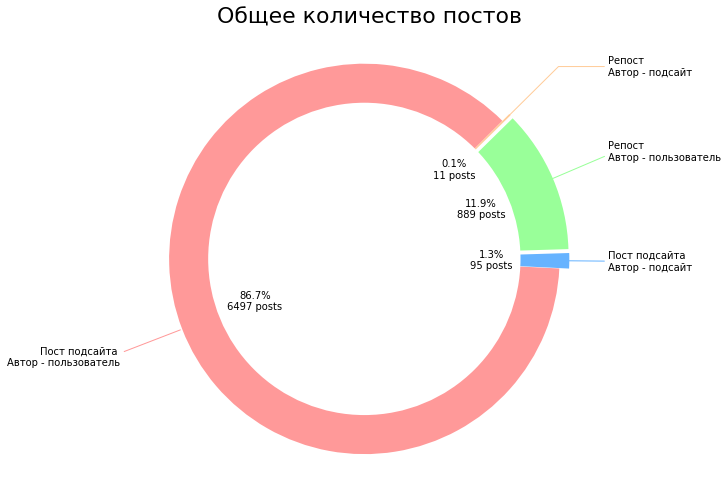

In [12]:
def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['id'],
    shadow=False,
    colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['id']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
                             "color":colors[i]
#                              "color":'b'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество постов', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [24]:
sns.set_theme()

In [13]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'comments_count': "sum"})
tmp

is_repost  author_type  comments_count
0      False            1           50754
1      False            2            1132
2       True            1           25252
3       True            2             542

In [14]:
tmp.comments_count.sum()

77680

In [15]:
sns.set_palette("tab10")

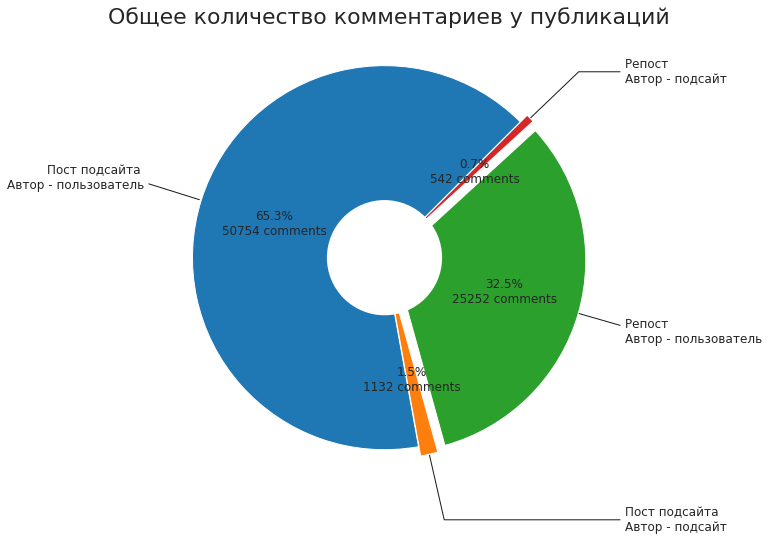

In [16]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} comments".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['comments_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['comments_count']), 
    explode=[0, 0.05, 0.05, 0.05]
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.3, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество комментариев у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/comments.jpg", dpi=300, bbox_inches='tight')

plt.show()

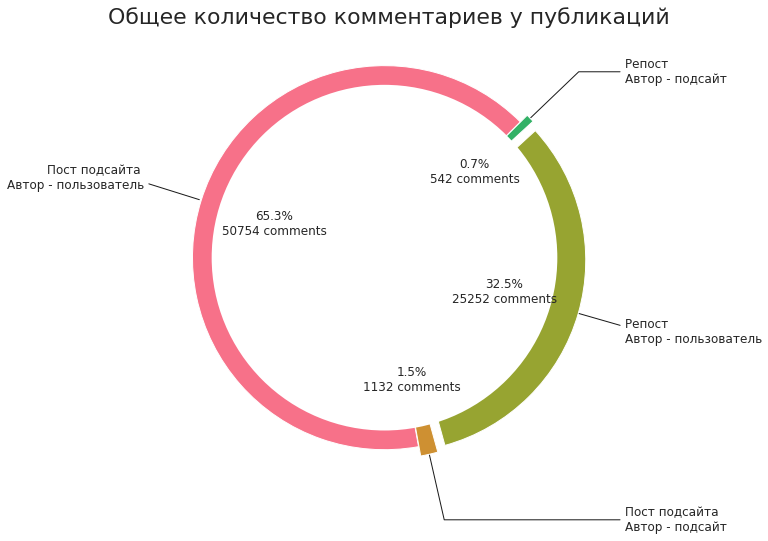

In [17]:
sns.set_palette("husl", 8)
fancy_pie_chart(tmp.comments_count, 'Общее количество комментариев у публикаций', 'test_1.jpg', donut_hole=0.9)

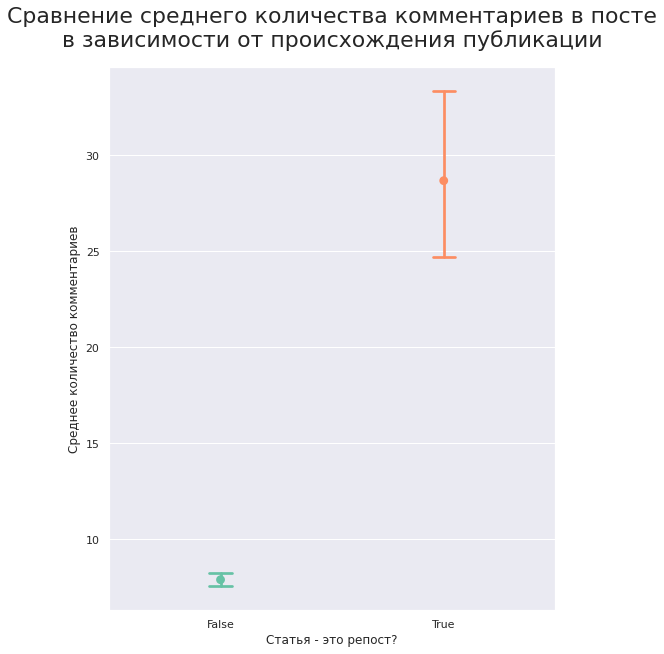

In [18]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="comments_count", 
                   data=df, join=False, capsize=.1, palette="Set2")

plt.title('Сравнение среднего количества комментариев в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество комментариев')
plt.xlabel('Статья - это репост?')

plt.savefig(PATH + "Full_analysis/comments_compare.jpg", dpi=300, bbox_inches='tight')

In [19]:
df.groupby(['is_repost']).agg({'comments_count': ['mean', 'std']})

comments_count           
                    mean        std
is_repost                          
False           7.871056  13.358577
True           28.660000  64.384620

In [20]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'hits_count': "sum"})
tmp

is_repost  hits_count
0      False     1721230
1       True     1102651

In [21]:
tmp.hits_count.sum()

2823881

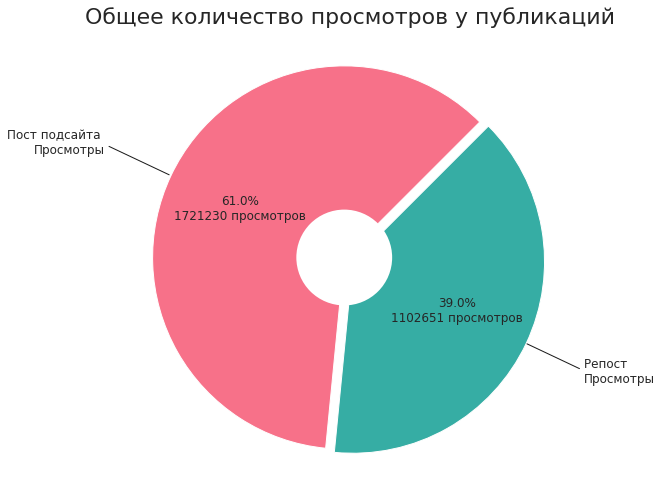

In [22]:
sns.set_palette("husl", 2)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} просмотров".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nПросмотры',  
          'Репост \nПросмотры', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['hits_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['hits_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.25, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество просмотров у публикаций', fontsize=22, pad=20)

plt.axis('equal')

plt.savefig(PATH + "Full_analysis/hits.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [23]:
labels = ['Пост подсайта \nПросмотры',  
          'Репост \nПросмотры', ]
fancy_pie_chart(tmp.hits_count, donut_hole=0.3, labels=labels)

TypeError: fancy_pie_chart() missing 2 required positional arguments: 'title' and 'path'

In [ ]:
# sns.boxplot(x="is_repost", y="hits_count", data=df)

In [ ]:
df.columns

Text(0.5, 0, 'Статья - это репост?')

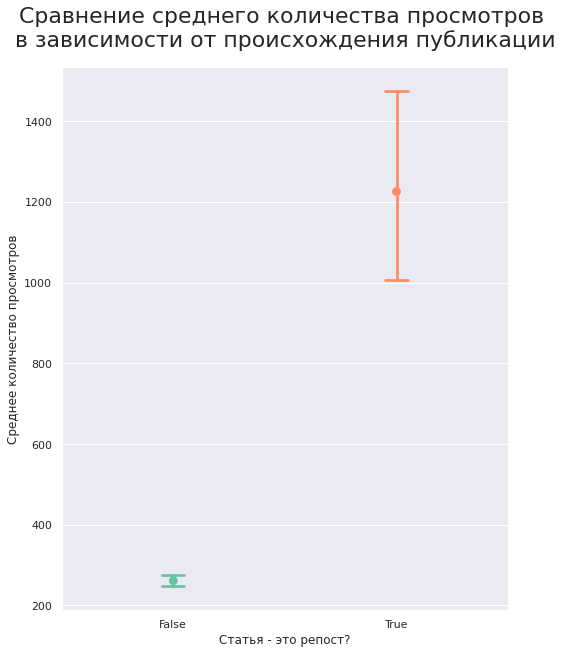

In [24]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="hits_count", 
                   data=df, join=False, capsize=.1, palette="Set2")

plt.title('Сравнение среднего количества просмотров \nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество просмотров')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/hits_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['is_repost']).agg({'hits_count': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'favorites_count': "sum"})
tmp

In [ ]:
tmp.favorites_count.sum()

KeyError: 'favorites_count'

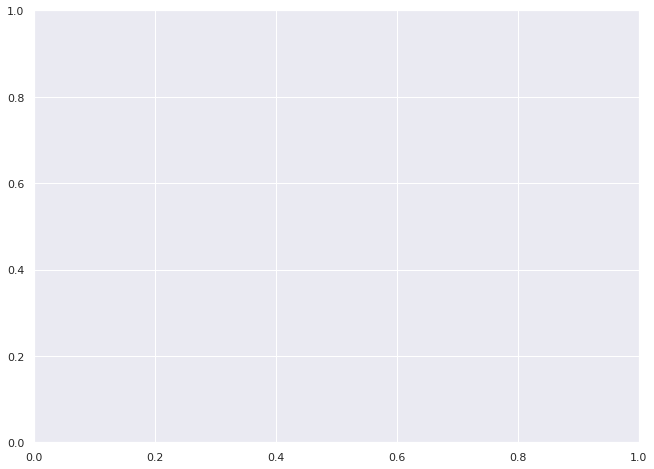

In [25]:
sns.set_palette("hls", 4)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} ДвЗ".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nДобавлений в закладки',  
          'Репост \nДобавлений в закладки', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['favorites_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['favorites_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество добавлений в закладки у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/favs.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'favorites_count': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="favorites_count", 
                   data=df, join=False, capsize=.1, palette="hls")

plt.title('Сравнение среднего количества добавлений в закладки поста\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество ДвЗ')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/favs_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'likes': "sum"})
tmp

In [ ]:
tmp.likes.sum()

In [ ]:
sns.set_palette("icefire_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} likes".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['likes'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['likes']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество лайков у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="likes", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества лайков у поста\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество лайков')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/likes_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['is_repost']).agg({'likes': ['mean', 'std']})

In [ ]:
tmp_symbols = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'symbols': "sum"})
tmp_symbols

In [ ]:
tmp_symbols.symbols.sum()

In [ ]:
sns.set_palette("husl")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} символов".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_symbols['symbols'],
    shadow=False,
#     colors=colors, 
    startangle=135, #frame=True, 
    autopct=lambda pct: func(pct, tmp_symbols['symbols']), 
    explode=(0, 0.05, 0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.89, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество символов в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/symbols.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'symbols': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="symbols", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества символов в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество символов')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/symbols_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# total = sum(tmp_symbols.symbols)
# proportions = [(float(value) / total) for value in tmp_symbols.symbols]

In [ ]:
# width = 40
# height=10
# total= width * height
# tiles_per_category = [round(proportion * total) for proportion in proportions]

In [ ]:
# waffle = np.zeros((height, width))
# category_index = 0
# tile_index = 0

# for col in range(width):
#     for row in range(height):
#         tile_index += 1
#         if tile_index > sum(tiles_per_category[0:category_index]):
#             category_index += 1
#         waffle[row, col] = category_index

# # fig = plt.figure()
# # colormap = plt.cm.coolwarm
# # plt.matshow(waffle, cmap=colormap)
# # plt.colorbar()

# fig = plt.figure()
# colormap = plt.cm.coolwarm
# plt.matshow(waffle, cmap=colormap)
# ax = plt.gca()
# ax.set_xticks(np.arange(-0.5, (width), 1), minor=True)
# ax.set_yticks(np.arange(-0.5, (height), 1), minor=True)
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
# plt.xticks([])
# plt.yticks([])
# plt.colorbar()

https://github.com/laserson/squarify#Documentation-for-Squarify

https://pypi.org/project/pywaffle/

https://pypi.org/project/squarify/#history

https://plotly.com/python/treemaps/

https://towardsdatascience.com/treemap-basics-with-python-777e5ed173d0

https://towardsdatascience.com/creating-compelling-pie-chart-alternatives-3a1c2c2889b8

https://stackoverflow.com/questions/3282935/treemap-visualization-in-python

https://towardsdatascience.com/waffle-charts-using-pythons-matplotlib-94252689a701

In [ ]:
tmp_symbols

In [26]:
from pywaffle import Waffle

labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
d = {lab: val for lab, val in zip(labels, tmp_symbols.symbols.values)}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=9, 
    values=list(tmp_symbols.symbols/9500),
#     labels=labels,
    title={
        'label': 'Количество символов в публикациях',
        'loc': 'center',
        'fontdict': {
            'fontsize': 20
        }
    },
#     labels=[f"{k} ({int(v / sum(d.values()) * 100)}%)" for k, v in d.items()],
    legend={
        'labels': [f"{k} ({v} единиц, {round(v/sum(d.values())*100,2)}%)" for k, v in d.items()],  # labels could also be under legend instead
        'loc': 'lower left',
        'bbox_to_anchor': (0.02, -0.2),
        'ncol': len(labels),
        'framealpha': 0,
        'fontsize': 12
    },
    figsize=(22, 8),
#     legend={'bbox_to_anchor': (1.3, 0.85)}    
)
# plt.savefig(PATH + "Full_analysis/symbols_waffle.jpg", dpi=300, bbox_inches='tight')

NameError: name 'tmp_symbols' is not defined

In [ ]:
sum(d.values())

In [13]:
tmp_media = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'total_mediacontent': "sum"})
tmp_media

is_repost  author_type  total_mediacontent
0      False            1               25937
1      False            2                 171
2       True            1               12001
3       True            2                 199

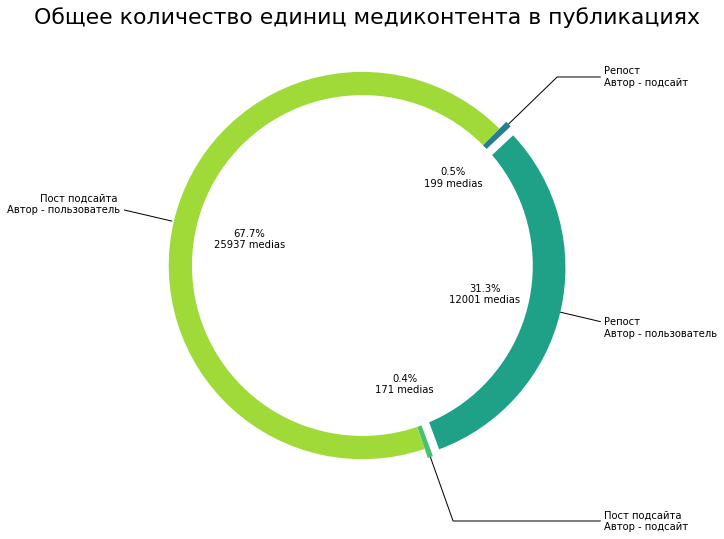

In [14]:
sns.set_palette("viridis_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} medias".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_media['total_mediacontent'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp_media['total_mediacontent']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.88, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество единиц медиконтента в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/medias.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'total_mediacontent': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="total_mediacontent", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества медиаконтента в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество медиаконтента')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/medias_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
tmp_media

In [ ]:
tmp_media.total_mediacontent.sum()

In [ ]:
from pywaffle import Waffle

labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
d = {lab: val for lab, val in zip(labels, tmp_media.total_mediacontent.values)}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=13, 
    values=list(tmp_media.total_mediacontent/70.1),
#     labels=labels,
    title={
        'label': 'Количество медиаконтента в публикациях',
        'loc': 'center',
        'fontdict': {
            'fontsize': 20
        }
    },
#     labels=[f"{k} ({int(v / sum(d.values()) * 100)}%)" for k, v in d.items()],
    legend={
        'labels': [f"{k} ({v} единиц, {round(v/sum(d.values())*100,2)}%)" for k, v in d.items()],  # labels could also be under legend instead
        'loc': 'lower left',
        'bbox_to_anchor': (0.07, -0.2),
        'ncol': len(labels),
        'framealpha': 0,
        'fontsize': 12
    },
    figsize=(22, 8),
#     legend={'bbox_to_anchor': (1.3, 0.85)}    
)
# plt.savefig(PATH + "Full_analysis/media_waffle.jpg", dpi=300, bbox_inches='tight')

In [15]:
print(len(df.author_name.unique()))
print(len(df[df.is_repost == False].author_name.unique()))
print(len(df[df.is_repost == True].author_name.unique()))

440
340
200


In [16]:
author_set_post = set(df[df.is_repost == False].author_name.unique())
author_set_repost = set(df[df.is_repost == True].author_name.unique())

#### Venn diagram

https://pypi.org/project/matplotlib-venn/
    
https://stackoverflow.com/questions/55622820/python-venn-diagram-actual-label

https://stackoverflow.com/questions/55717203/plot-actual-set-items-in-python-not-the-number-of-items/55718006#55718006

https://stackoverflow.com/questions/42855256/python-venn-diagram-how-to-show-the-diagram-contents

https://stackoverflow.com/questions/46224235/matplotlib-venn-diagram-with-legend

https://stackoverflow.com/questions/51052573/matplotlib-venn-changing-what-is-displayed-inside-the-venn-diagram

https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram

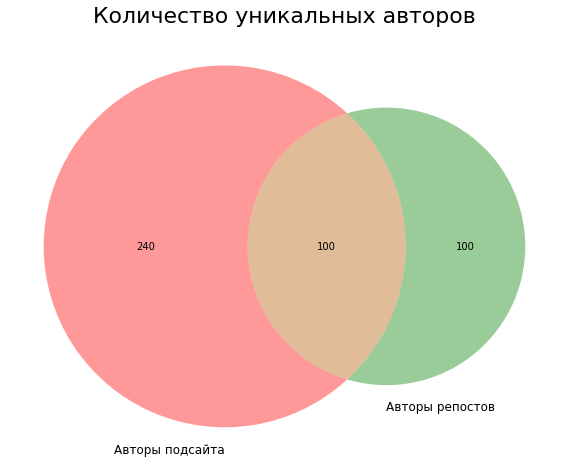

In [17]:
# Plotting Venn diagramm
from matplotlib_venn import venn2
plt.figure(figsize=(14,8))

venn = venn2([author_set_post, author_set_repost], ('Авторы подсайта', 'Авторы репостов'))

# venn.get_label_by_id('100').set_text('\n'.join(map(str, author_set_post-author_set_repost)))
# venn.get_label_by_id('110').set_text('\n'.join(map(str, author_set_post&author_set_repost)))
# venn.get_label_by_id('010').set_text('\n'.join(map(str, author_set_repost-author_set_post)))

plt.title('Количество уникальных авторов', fontsize=22)

# plt.savefig(PATH + "Full_analysis/authors_venn.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# feature_cols = ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols', 'words', 
#                 'images', 'videos', 'links', 'audio', 'total_mediacontent']

In [ ]:
# fig, axs = plt.subplots(ncols = 3,nrows = 1, figsize = (36,8.5))
# for i,j in enumerate(feature_cols[0:3]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes', ascending = False)[j],
#                 palette = "mako")
# fig.suptitle("likes", fontsize=30)

# fig, axs = plt.subplots(ncols = 8,nrows = 1, figsize = (36,5))
# for i,j in enumerate(feature_cols[3:11]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes',ascending = False)[j],
#                 palette = "mako")

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]
sns.set_theme()
sns.color_palette()

In [ ]:
# sns.scatterplot(x=df.symbols, size=df.likes, hue='is_repost', 
#                 y=sum([df.images, df.videos, df.links]), data=df)

# Разбираемся с построением столбчатых диаграмм

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/40066089/apply-images-to-pyplot-python-bar-graphs

# СУПЕР_ВАЖНО!

```python
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

labels = ['CW', 'CV', 'GW', 'SX', 'DO']
colors = ['crimson', 'dodgerblue', 'teal', 'limegreen', 'gold']
values = 30 + np.random.randint(5, 20, len(labels)).cumsum()

height = 0.9
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    # with cbook.get_sample_data('ada.png') as image_file:
    #    img = plt.imread(image_file)
    response = requests.get(f'https://www.countryflags.io/{label}/flat/64.png')
    img = plt.imread(BytesIO(response.content))
    plt.imshow(img, extent=[value - 8, value - 2, i - height / 2, i + height / 2], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()
```

# МЕГА-ВАЖНО!

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python

In [ ]:
# Первый, неудачный вариант

# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp.index[:5]
# colors = ['tan', 'peru', 'grey', 'orchid', 'darkred']
# values = tmp.values.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp.index[:5], width=tmp.values.flatten()[:5], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index

### Tests

In [ ]:
# tmp_2 = df.groupby(['author_name','author_avatar_url'], as_index=False).count() \
# .sort_values(by="id", ascending=False).head(20).iloc[:, [0,1,3]]
# tmp_2

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)

# plt.style.use('seaborn')    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

In [ ]:
# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# f = sns.barplot(y=tmp_2.author_name[:5][::-1], x=tmp_2.id[:5][::-1])
# ax = f

# for p in ax.patches:
#     width = p.get_width()    # get bar length
#     ax.text(width + 1,       # set the text at 1 unit right of the bar
#             p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#             '{:1.0f}'.format(width), # set variable to display, 2 decimals
#             ha = 'left',   # horizontal alignment
#             va = 'center')  # vertical alignment

# # for i, (label, value) in enumerate(zip(labels, values)):
# #     im = Image.open(requests.get(label, stream=True).raw)
# #     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# # plt.xlim(0, max(values) * 1.05)
# # plt.ylim(-0.5, len(labels) - 0.5)
# # plt.tight_layout()
# # plt.show()

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] 

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
#     plt.text(value + 3, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn

https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart

### Tests end
# Конец тестовой зоны

# Смотрим на топы по различным признакам

In [18]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(20)
tmp

author_name
олег уходи                       876
Layben                           787
Гусь Хмурый                      470
Suzume-sama said OKawaii Koto    406
Diego Paw                        336
Фанат Ани Тейлор-Джой            274
Pray for Megumin                 255
Just Chill                       251
Хасаги                           199
Koda                             136
Over9k5000                       121
mindtered                        113
Oleg Mattewho                    100
Виабу                             93
Анимемания                        86
YuruCamp каждый день              84
Алексей Кудрявцев                 80
Saher                             78
Marshal_New_Arleana               66
Revendi                           66
Name: author_name, dtype: int64

In [34]:
df["date_alter"] = df.date.dt.date

In [31]:
df.head()

date      id  \
0 2018-03-12 21:59:15   17110   
1 2020-01-26 20:38:21   97215   
2 2020-02-18 19:11:46  104163   
3 2020-02-29 18:25:10  108055   
4 2020-03-16 10:36:03  113363   

                                                 url  \
0   https://dtf.ru/flood/17110-ne-odin-lish-tip-luny   
1  https://dtf.ru/u/92907-aleksey-fedorov/97215-t...   
2  https://dtf.ru/u/92907-aleksey-fedorov/104163-...   
3  https://dtf.ru/u/92907-aleksey-fedorov/108055-...   
4  https://dtf.ru/u/4810-oleg-kubaneishvili/11336...   

                                              author  comments_count  \
0  {'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...              19   
1  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...              11   
2  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...              39   
3  {'id': 92907, 'url': 'https://dtf.ru/u/92907-a...               7   
4  {'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...               5   

   favorites_count  hits_count  is_repost  likes            subsite  ...  \
0               32        1999       True     36              Офтоп  ...   
1               47         665       True     56    Алексей Фёдоров  ...   
2               23         749       True     49    Алексей Фёдоров  ...   
3               18         238       True     41    Алексей Фёдоров  ...   
4                8         180       True     15  Олег Кубанеишвили  ...   

  audio total_mediacontent               hashtags hour month   weekday  \
0     0                 45                [#long]   21     3    Monday   
1     0                 17               [#anime]   20     1    Sunday   
2     0                 32  [#anime, #evangelion]   19     2   Tuesday   
3     0                 20               [#anime]   18     2  Saturday   
4     0                 17                     []   10     3    Monday   

  is_weekend   period  type_of_post  date_alter  
0          0  2018-03       Лонгрид  2018-03-12  
1          1  2020-01        Статья  2020-01-26  
2          0  2020-02      Подборка  2020-02-18  
3          1  2020-02      Подборка  2020-02-29  
4          0  2020-03       Лонгрид  2020-03-16  

[5 rows x 32 columns]

In [32]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(50)
tmp.index

Index(['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'StupidMaronGuy', 'Тимур Лебедев',
       'Валера Чумаков', 'IcEWaRRiOr', 'Kits R', 'BioHazardAlBatros', 'Bsod',
       'Maks-arr', 'Hero', 'Мимо Проходил', 'Андрей Тор4'],
      dtype='object', name='author_name')

In [33]:
test = df.groupby(['date_alter', 'author_name']).agg({"id": "count"})
test

id
date_alter author_name                       
2018-03-12 Georgy Georgiev                  1
2020-01-26 Алексей Фёдоров                  1
2020-02-18 Алексей Фёдоров                  1
2020-02-29 Алексей Фёдоров                  1
2020-03-16 Олег Кубанеишвили                1
...                                        ..
2021-05-01 Петя Миров                       1
           олег уходи                       2
2021-05-02 Barracuda                        1
           Layben                           2
           Секрекрекрекрекрекрекрекрекрет   1

[4242 rows x 1 columns]

In [34]:
test.index.get_level_values(0)

Index([2018-03-12, 2020-01-26, 2020-02-18, 2020-02-29, 2020-03-16, 2020-06-22,
       2020-07-13, 2020-07-14, 2020-07-14, 2020-07-14,
       ...
       2021-05-01, 2021-05-01, 2021-05-01, 2021-05-01, 2021-05-01, 2021-05-01,
       2021-05-01, 2021-05-02, 2021-05-02, 2021-05-02],
      dtype='object', name='date_alter', length=4242)

In [35]:
test.pivot_table(values='id', index=test.index.get_level_values(0), columns='author_name').cumsum()

author_name  1stStarman  2B OR NOT 2B  A4Y  Adakond  Alek  Aleksej Gorbunow  \
date_alter                                                                    
2018-03-12          NaN           NaN  NaN      NaN   NaN               NaN   
2020-01-26          NaN           NaN  NaN      NaN   NaN               NaN   
2020-02-18          NaN           NaN  NaN      NaN   NaN               NaN   
2020-02-29          NaN           NaN  NaN      NaN   NaN               NaN   
2020-03-16          NaN           NaN  NaN      NaN   NaN               NaN   
...                 ...           ...  ...      ...   ...               ...   
2021-04-28          1.0           NaN  NaN      NaN   NaN               NaN   
2021-04-29          2.0           NaN  NaN      NaN   NaN               NaN   
2021-04-30          3.0           NaN  NaN      NaN   NaN               NaN   
2021-05-01          NaN           NaN  NaN      NaN   NaN               NaN   
2021-05-02          NaN           NaN  NaN      NaN   NaN               NaN   

author_name  Aleksey Loshkarev  Alex Cross  Alex Dar  Alex Eject  ...  \
date_alter                                                        ...   
2018-03-12                 NaN         NaN       NaN         NaN  ...   
2020-01-26                 NaN         NaN       NaN         NaN  ...   
2020-02-18                 NaN         NaN       NaN         NaN  ...   
2020-02-29                 NaN         NaN       NaN         NaN  ...   
2020-03-16                 NaN         NaN       NaN         NaN  ...   
...                        ...         ...       ...         ...  ...   
2021-04-28                 NaN         NaN       NaN         2.0  ...   
2021-04-29                 NaN         NaN       NaN         NaN  ...   
2021-04-30                 NaN         NaN       NaN         NaN  ...   
2021-05-01                 NaN         NaN       NaN         NaN  ...   
2021-05-02                 NaN         NaN       NaN         NaN  ...   

author_name  как же я задолбался  курияниヾ  локоток  олег уходи  смари умираю  \
date_alter                                                                      
2018-03-12                   NaN       NaN      NaN         NaN           NaN   
2020-01-26                   NaN       NaN      NaN         NaN           NaN   
2020-02-18                   NaN       NaN      NaN         NaN           NaN   
2020-02-29                   NaN       NaN      NaN         NaN           NaN   
2020-03-16                   NaN       NaN      NaN         NaN           NaN   
...                          ...       ...      ...         ...           ...   
2021-04-28                   NaN       NaN      NaN       872.0           NaN   
2021-04-29                  11.0       NaN      NaN       874.0           NaN   
2021-04-30                   NaN       NaN      NaN         NaN           NaN   
2021-05-01                   NaN       NaN      NaN       876.0           NaN   
2021-05-02                   NaN       NaN      NaN         NaN           NaN   

author_name  фан клуб парня в зеркале  アリクサンダ パイナップル  ウクライナへの栄光 Мамин Либерал  \
date_alter                                                                      
2018-03-12                        NaN            NaN                      NaN   
2020-01-26                        NaN            NaN                      NaN   
2020-02-18                        NaN            NaN                      NaN   
2020-02-29                        NaN            NaN                      NaN   
2020-03-16                        NaN            NaN                      NaN   
...                               ...            ...                      ...   
2021-04-28                        NaN            NaN                      NaN   
2021-04-29                        NaN            NaN                      NaN   
2021-04-30                        NaN            NaN                      NaN   
2021-05-01                        NaN            NaN                      NaN

In [36]:
test_v2 = test.pivot_table(values='id', index=test.index.get_level_values(0), columns='author_name').cumsum()

In [37]:
test_v2.fillna(method='ffill', inplace=True)

In [38]:
test_v2.iloc[0, :].fillna(0, inplace=True)

In [39]:
test_v2.fillna(method='ffill', inplace=True)

In [40]:
test_v2.isna().sum().unique()

array([0])

In [41]:
test_v2.index = pd.to_datetime(test_v2.index)

In [42]:
test_v2.tail()

author_name  1stStarman  2B OR NOT 2B  A4Y  Adakond  Alek  Aleksej Gorbunow  \
date_alter                                                                    
2021-04-28          1.0           3.0  3.0      1.0   2.0               2.0   
2021-04-29          2.0           3.0  3.0      1.0   2.0               2.0   
2021-04-30          3.0           3.0  3.0      1.0   2.0               2.0   
2021-05-01          3.0           3.0  3.0      1.0   2.0               2.0   
2021-05-02          3.0           3.0  3.0      1.0   2.0               2.0   

author_name  Aleksey Loshkarev  Alex Cross  Alex Dar  Alex Eject  ...  \
date_alter                                                        ...   
2021-04-28                 2.0         1.0       3.0         2.0  ...   
2021-04-29                 2.0         1.0       3.0         2.0  ...   
2021-04-30                 2.0         1.0       3.0         2.0  ...   
2021-05-01                 2.0         1.0       3.0         2.0  ...   
2021-05-02                 2.0         1.0       3.0         2.0  ...   

author_name  как же я задолбался  курияниヾ  локоток  олег уходи  смари умираю  \
date_alter                                                                      
2021-04-28                  10.0       4.0      8.0       872.0           1.0   
2021-04-29                  11.0       4.0      8.0       874.0           1.0   
2021-04-30                  11.0       4.0      8.0       874.0           1.0   
2021-05-01                  11.0       4.0      8.0       876.0           1.0   
2021-05-02                  11.0       4.0      8.0       876.0           1.0   

author_name  фан клуб парня в зеркале  アリクサンダ パイナップル  ウクライナへの栄光 Мамин Либерал  \
date_alter                                                                      
2021-04-28                        1.0            1.0                      1.0   
2021-04-29                        1.0            1.0                      1.0   
2021-04-30                        1.0            1.0                      1.0   
2021-05-01                        1.0            1.0                      1.0   
2021-05-02                        1.0            1.0                      1.0   

author_name  ヤン ウェンリー    💱  
date_alter                  
2021-04-28        5.0  1.0  
2021-04-29        5.0  1.0  
2021-04-30        5.0  1.0  
2021-05-01        5.0  1.0  
2021-05-02        5.0  1.0  

[5 rows x 440 columns]

https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

In [147]:
test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'StupidMaronGuy', 'Тимур Лебедев',
       'Валера Чумаков', 'IcEWaRRiOr', 'Kits R', 'BioHazardAlBatros', 'Bsod',
       'Maks-arr', 'Hero', 'Мимо Проходил', 'Андрей Тор4']]
# test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
#        'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
#        'Хасаги', 'Koda', 'Over9k5000']]

test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'Тимур Лебедев']]

In [148]:
test_v3.shape

(300, 40)

In [173]:
test_v3.to_csv(PATH + 'test.csv')

In [149]:
test_v3.loc['2021-05-02']

author_name
олег уходи                        876.0
Layben                            787.0
Гусь Хмурый                       470.0
Suzume-sama said OKawaii Koto     406.0
Diego Paw                         336.0
Фанат Ани Тейлор-Джой             274.0
Pray for Megumin                  255.0
Just Chill                        251.0
Хасаги                            199.0
Koda                              136.0
Over9k5000                        121.0
mindtered                         113.0
Oleg Mattewho                     100.0
Виабу                              93.0
Анимемания                         86.0
YuruCamp каждый день               84.0
Алексей Кудрявцев                  80.0
Saher                              78.0
Marshal_New_Arleana                66.0
Revendi                            66.0
deGoose                            54.0
Некстгенова Элой Плэйстэйшовна     53.0
Asuka Soryu                        51.0
Ржобек Пшеждзински                 50.0
Михаил Тучинский            

In [109]:
plt.rcParams["figure.figsize"] = [14, 20]

In [150]:
s = test_v3.loc['2021-01-25']

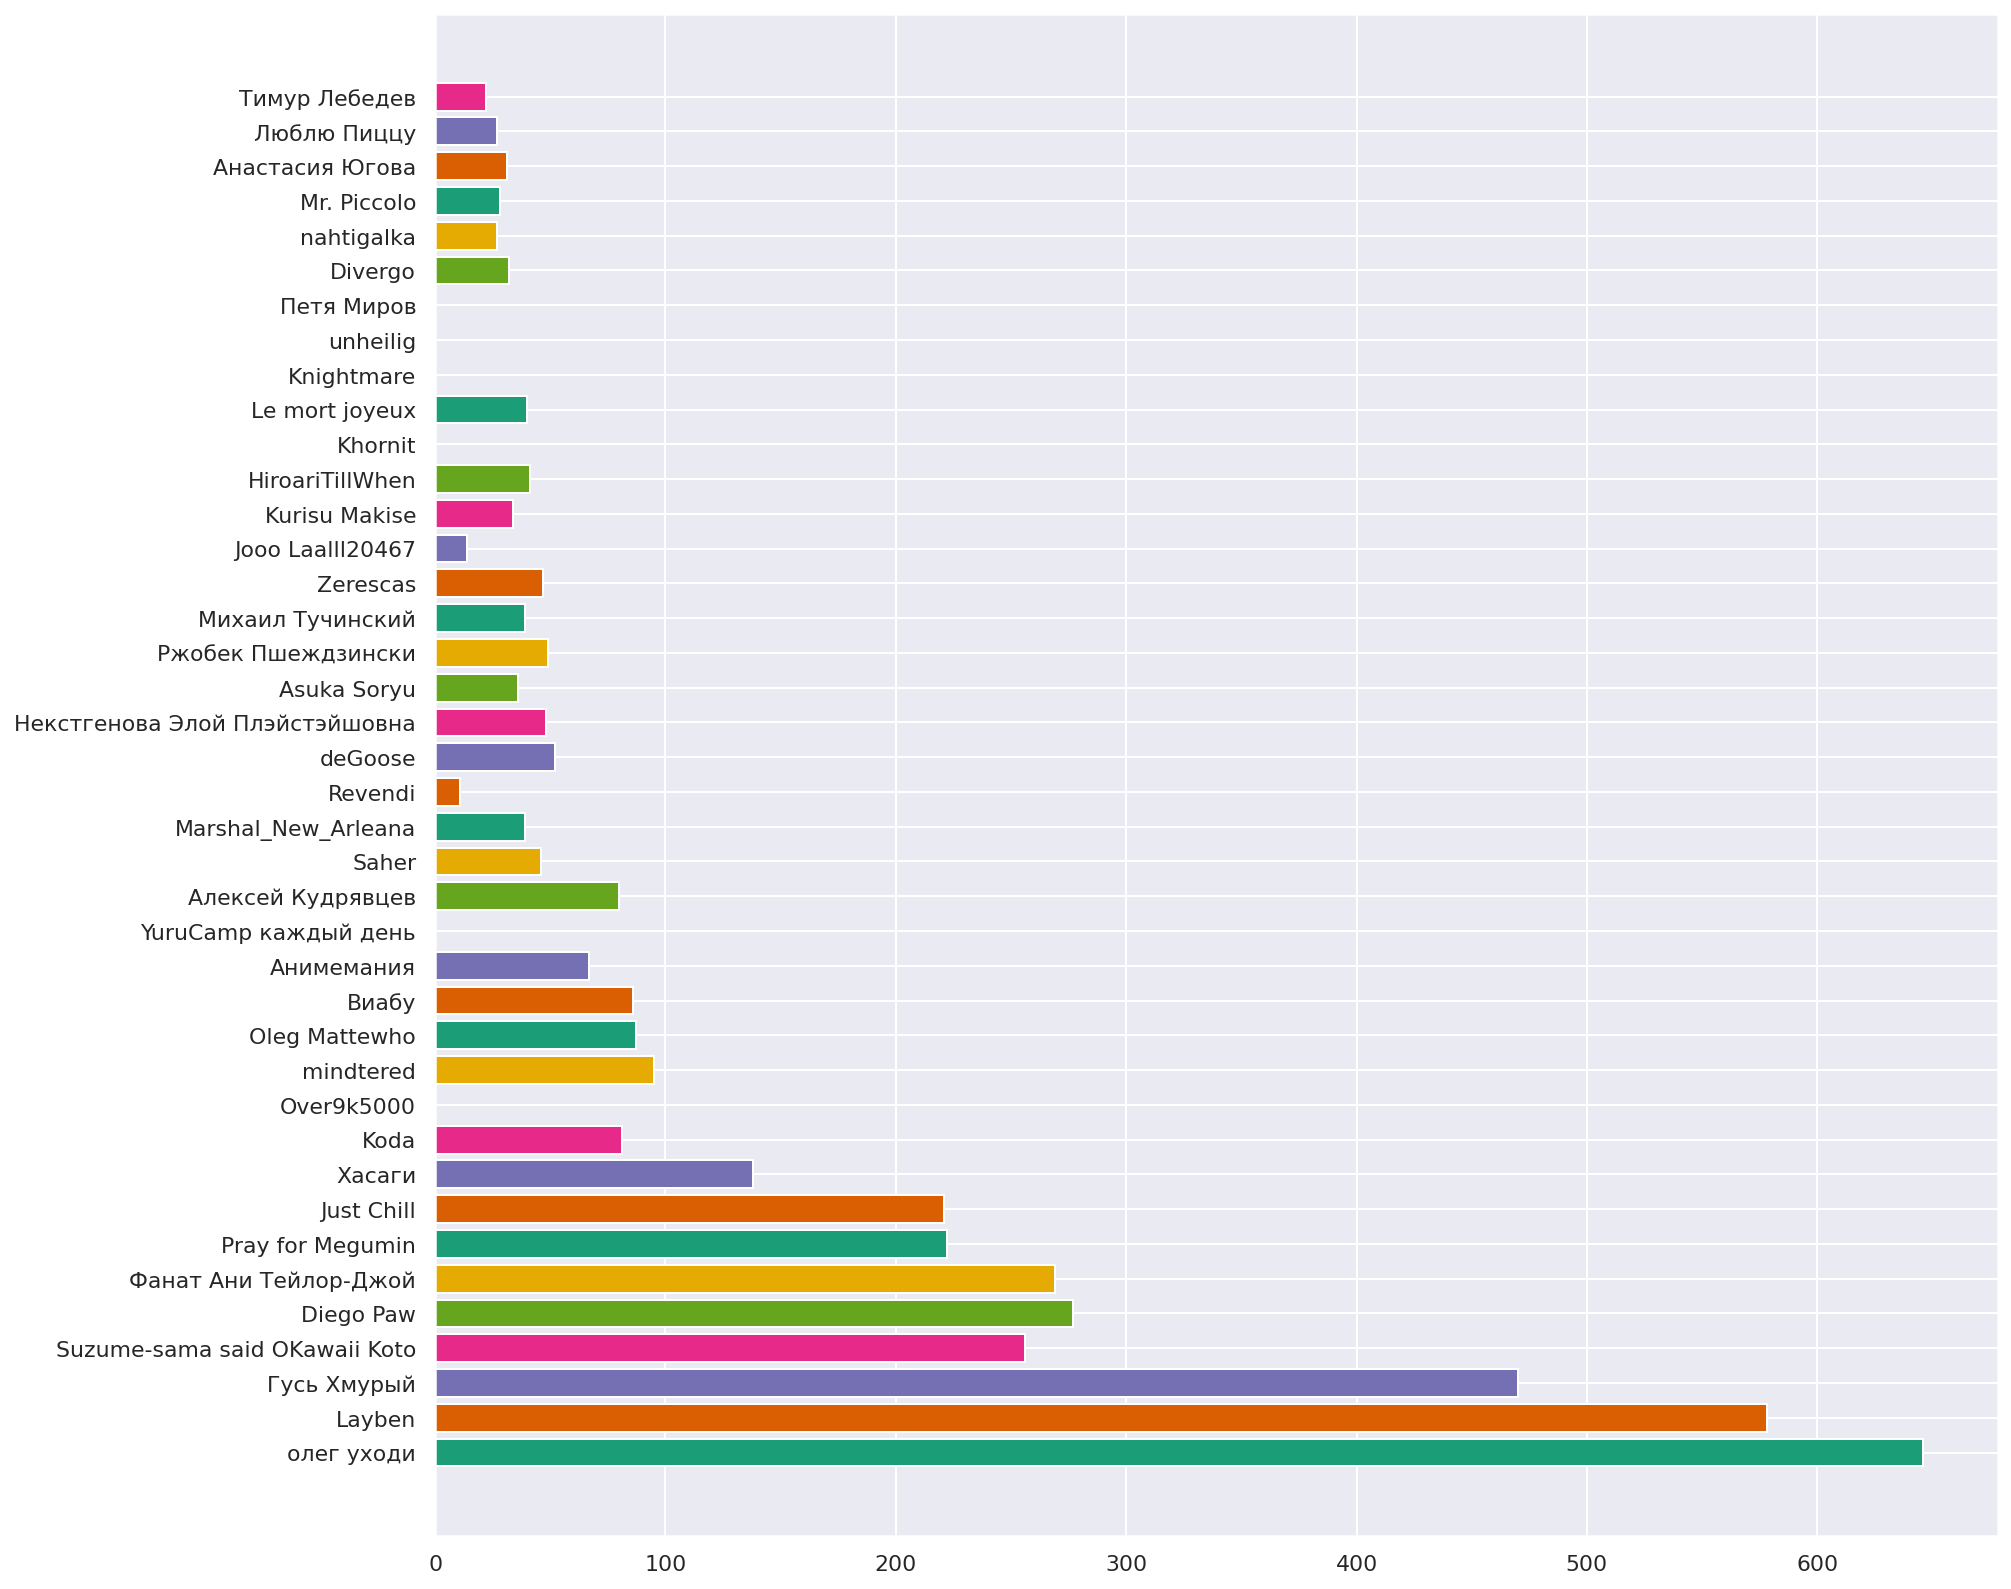

In [151]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 14), dpi=144)
colors = plt.cm.Dark2(range(6))
y = s.index
width = s.values
ax.barh(y=y, width=width, color=colors);

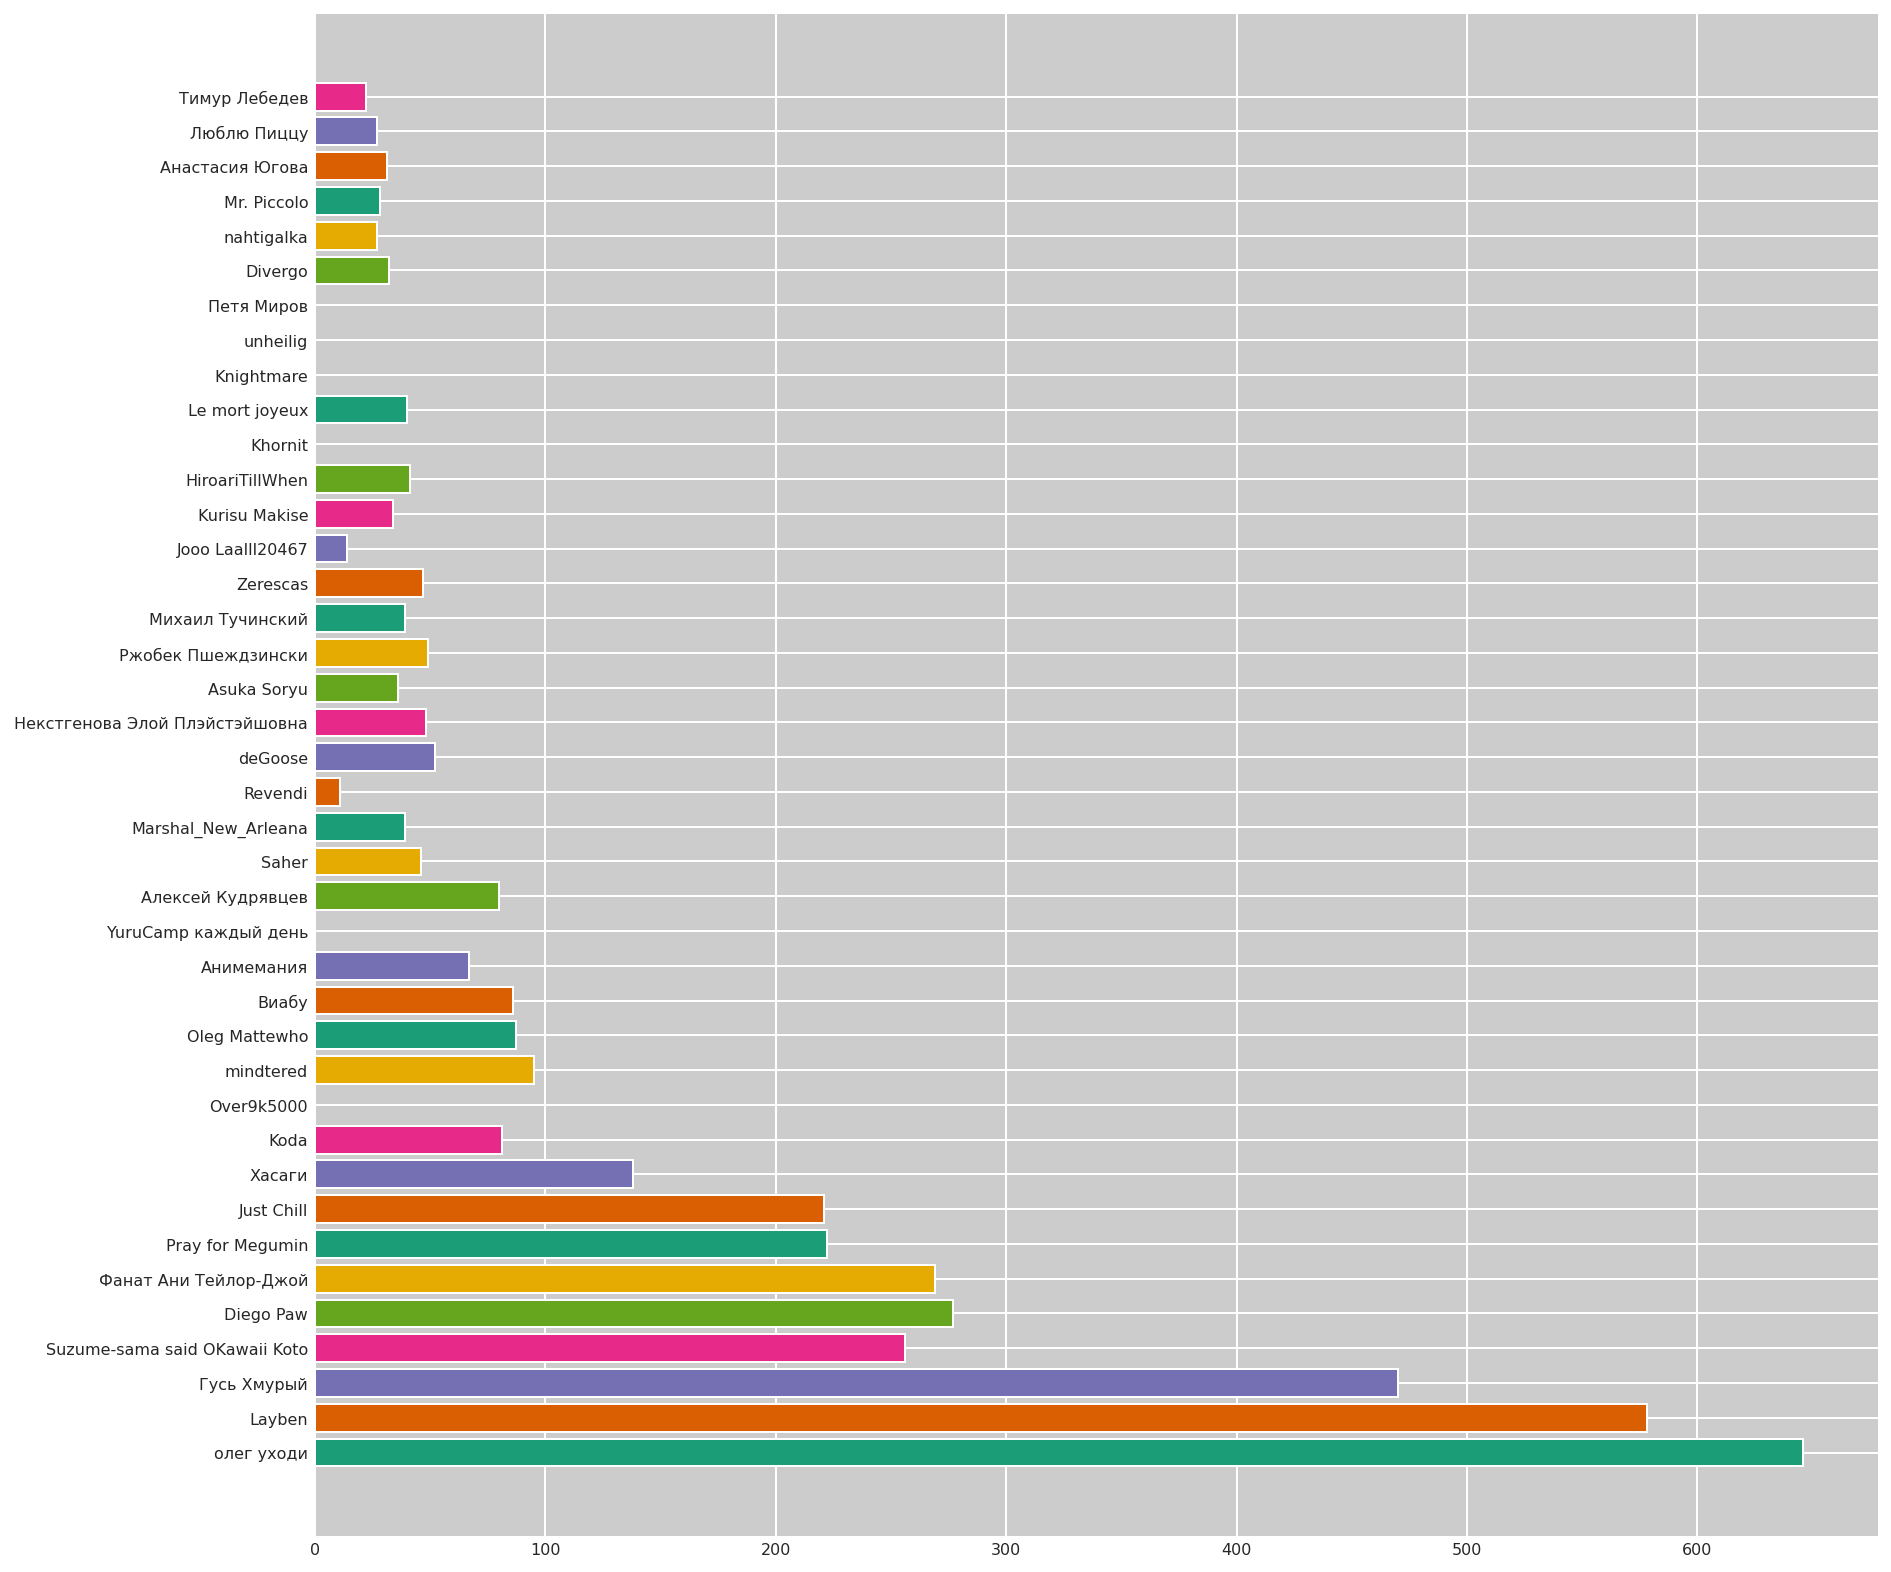

In [152]:
def nice_axes(ax):
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=8, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]
    
nice_axes(ax)
fig

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


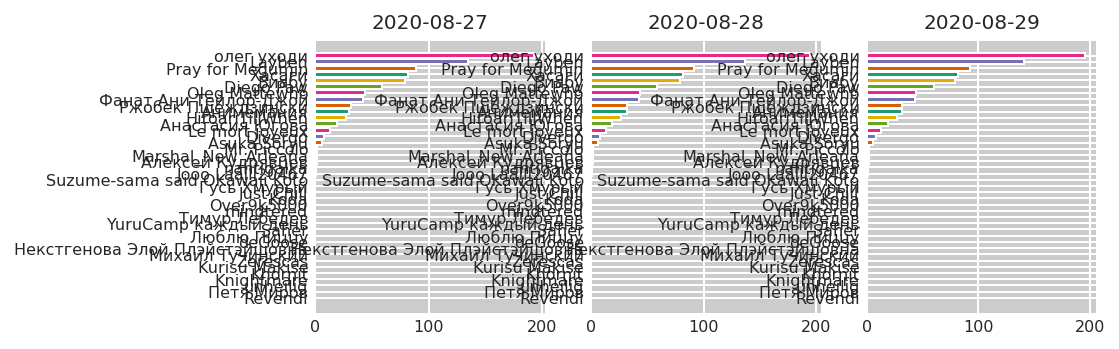

In [153]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-08-27', '2020-08-28', '2020-08-29']
for ax, date in zip(ax_array, dates):
    s = test_v3.loc[date].sort_values()
    ax.barh(y=s.index, width=s.values, color=colors)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

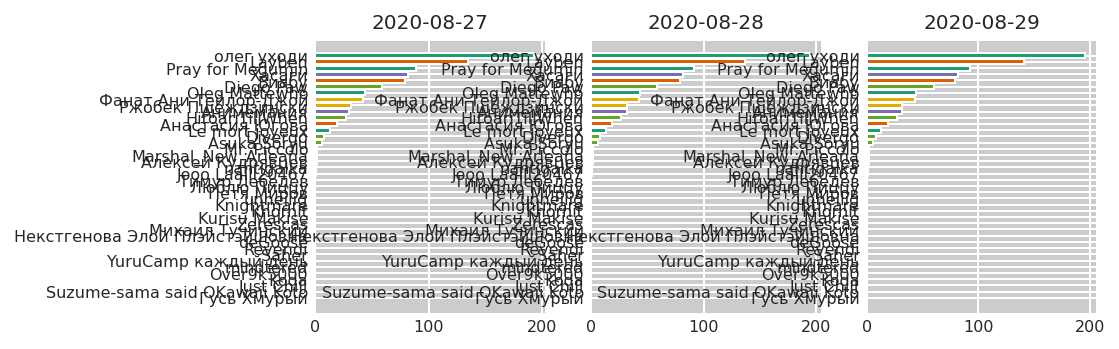

In [154]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-08-27', '2020-08-28', '2020-08-29']
for ax, date in zip(ax_array, dates):
    s = test_v3.loc[date]
    y = test_v3.loc[date].rank(method='first').values
    ax.barh(y=y, width=s.values, color=colors, tick_label=s.index)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

In [155]:
df2 = test_v3.reset_index()
last_idx = df2.index[-1] + 1
df_expanded = df2.reindex(range(last_idx))
df_expanded = df_expanded.set_index('date_alter')
df_rank_expanded = df_expanded.rank(axis=1, method='first')

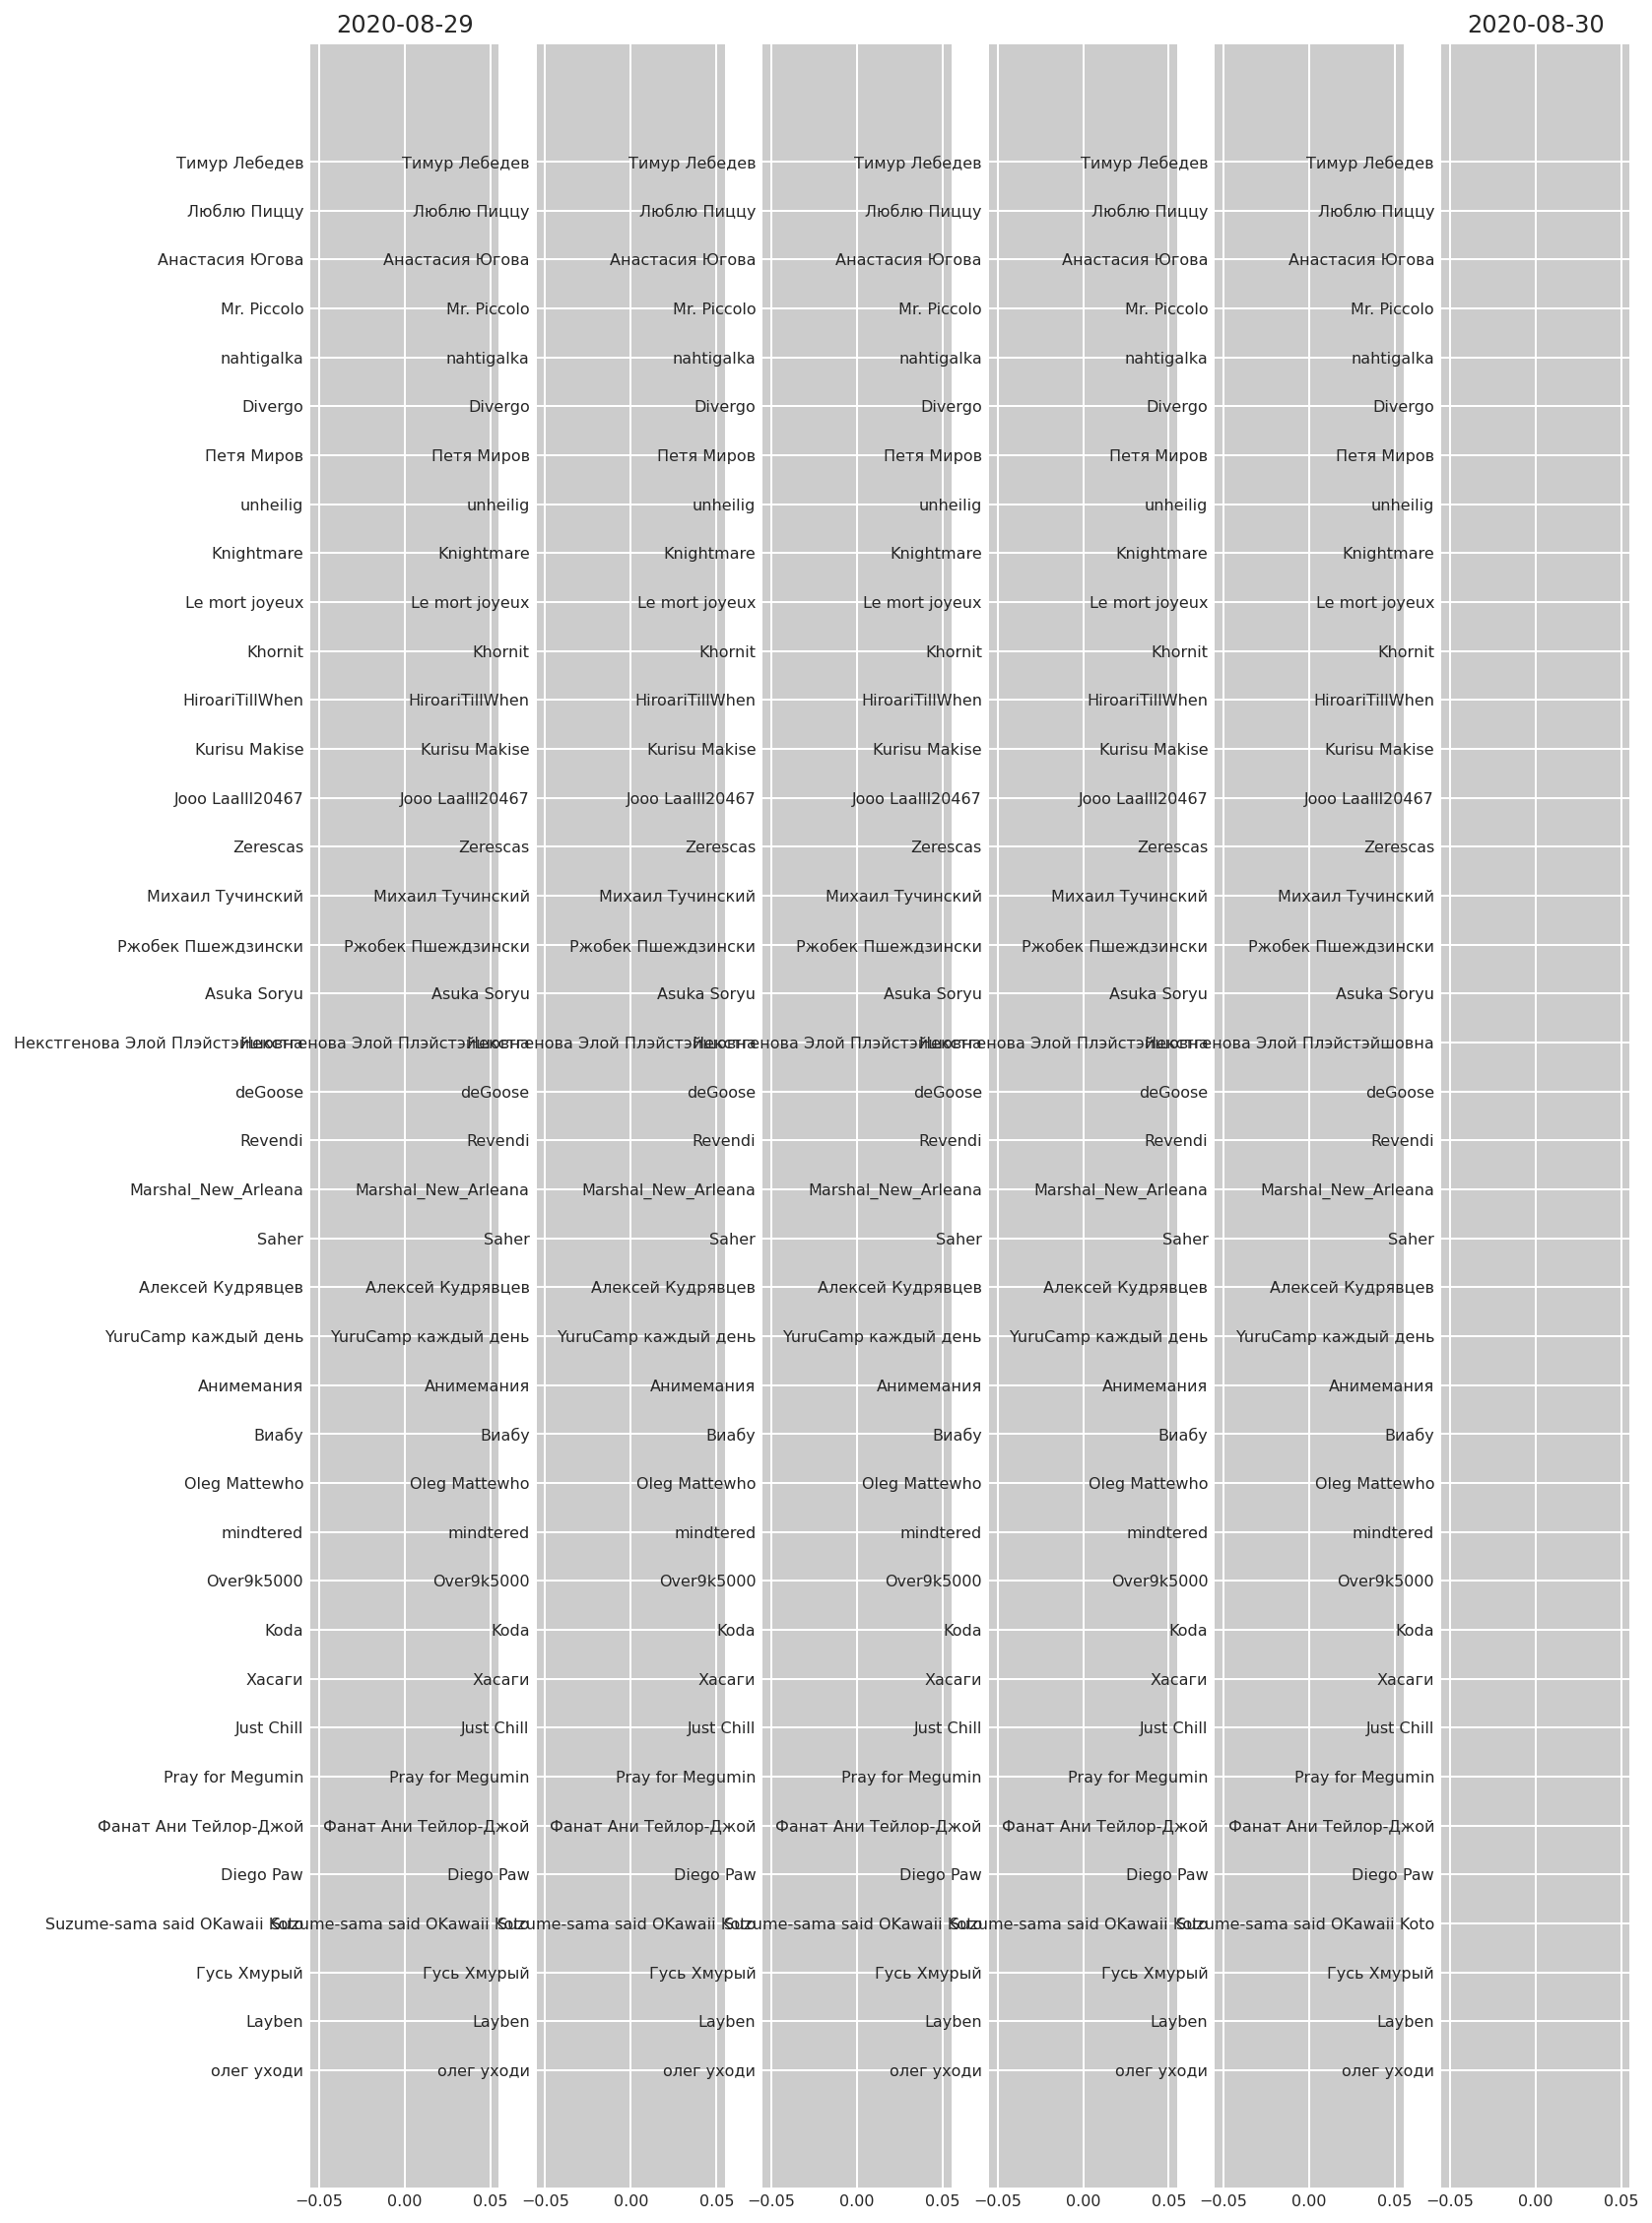

In [156]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 20), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten()):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-08-29')
ax_array[-1].set_title('2020-08-30');

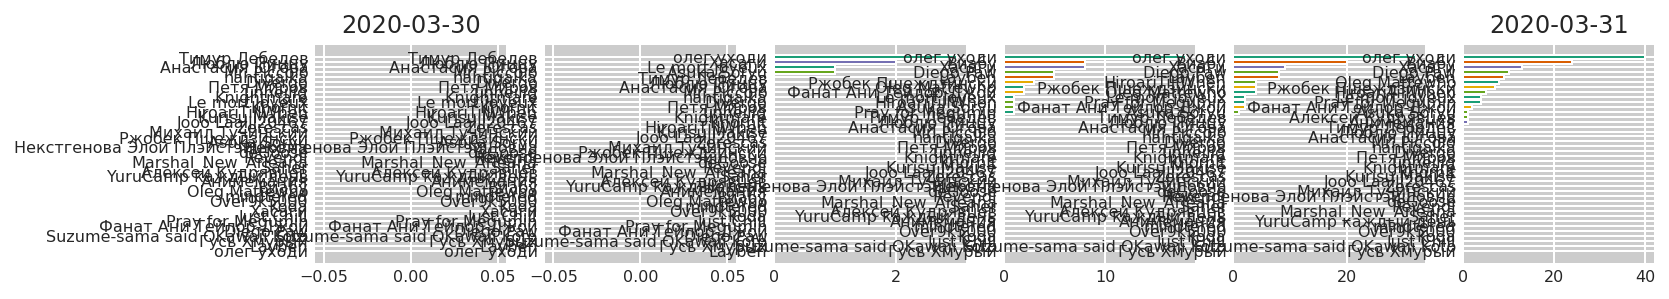

In [157]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 2), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten(), start=5):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-03-30')
ax_array[-1].set_title('2020-03-31');

In [162]:
from matplotlib.animation import FuncAnimation

def init():
    ax.clear()
    nice_axes(ax)

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%B %-d, %Y')
    ax.set_title(f'Количество публикаций пользователя - {date_str}', fontsize='smaller')
    ax.set_xlabel(f'Количество постов')
    ax.set_ylabel(f'Автор')
    ax.set_axisbelow(True)
    
fig = plt.Figure(figsize=(20, 9), dpi=144)
ax = fig.add_subplot()
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [163]:
from IPython.display import HTML
html = anim.to_html5_video()
HTML(html)

In [164]:
anim.save(PATH + 'posts_race.mp4')

https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096

# Alternative

https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41

In [180]:
# test_v3.head()

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# def draw_barchart(date):
#     dff = df[df['year'].eq(year)].sort_values(by='value', ascending=True).tail(10)
#     ax.clear()
#     ax.barh(dff['name'], dff['value'], color=[colors[group_lk[x]] for x in dff['name']])
#     dx = dff['value'].max() / 200
#     for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
#         ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
#         ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
#         ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
#     # ... polished styles
#     ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
#     ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#     ax.xaxis.set_ticks_position('top')
#     ax.tick_params(axis='x', colors='#777777', labelsize=12)
#     ax.set_yticks([])
#     ax.margins(0, 0.01)
#     ax.grid(which='major', axis='x', linestyle='-')
#     ax.set_axisbelow(True)
#     ax.text(0, 1.12, 'The most populous cities in the world from 1500 to 2018',
#             transform=ax.transAxes, size=24, weight=600, ha='left')

#     plt.box(False)
    
# draw_barchart(2018)

# ALTERNATIVE

https://www.dexplo.org/bar_chart_race/

In [172]:
import bar_chart_race as bcr

In [1]:
test_v3.index

NameError: name 'test_v3' is not defined

In [189]:
test_v4 = test_v3[test_v3.index < '2020-08-15']
test_v4 = test_v4[test_v4.index > '2020-07-13']
test_v4.shape

(32, 40)

Лучше рисовать это в Google Colab, меньше мороки. 

In [190]:
bcr.bar_chart_race(
    df=test_v4,
    filename=PATH + 'bcr.mp4',
    orientation='h',
    sort='desc',
    n_bars=40,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=100,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Общее количество постов от пользователей: {v.nlargest(40).sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=100,
    figsize=(10, 6),
    dpi=144,
    cmap='dark12',
    title='Топ-40 авторов по количеству постов',
    title_size='',
    
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)  

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


Exception: You do not have ffmpeg installed on your machine. Download
                            ffmpeg from here: https://www.ffmpeg.org/download.html.
                            
                            Matplotlib's original error message below:

                            Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1680x864', '-pix_fmt', 'rgba', '-r', '100.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/bcr.mp4']' returned non-zero exit status 255.
                            

In [176]:
# bcr_html = bcr.bar_chart_race(df=test_v3, filename=None)

In [36]:
new_test = df.groupby(['date_alter', 'author_name']).agg({"likes": "sum"})
new_test

likes
date_alter author_name                          
2018-03-12 Georgy Georgiev                    36
2020-01-26 Алексей Фёдоров                    56
2020-02-18 Алексей Фёдоров                    49
2020-02-29 Алексей Фёдоров                    41
2020-03-16 Олег Кубанеишвили                  15
...                                          ...
2021-05-01 Петя Миров                         17
           олег уходи                        226
2021-05-02 Barracuda                          40
           Layben                             44
           Секрекрекрекрекрекрекрекрекрет      1

[4242 rows x 1 columns]

In [38]:
new_test.pivot_table(values='likes', index=new_test.index.get_level_values(0), columns='author_name').cumsum()

author_name  1stStarman  2B OR NOT 2B  A4Y  Adakond  Alek  Aleksej Gorbunow  \
date_alter                                                                    
2018-03-12          NaN           NaN  NaN      NaN   NaN               NaN   
2020-01-26          NaN           NaN  NaN      NaN   NaN               NaN   
2020-02-18          NaN           NaN  NaN      NaN   NaN               NaN   
2020-02-29          NaN           NaN  NaN      NaN   NaN               NaN   
2020-03-16          NaN           NaN  NaN      NaN   NaN               NaN   
...                 ...           ...  ...      ...   ...               ...   
2021-04-28         10.0           NaN  NaN      NaN   NaN               NaN   
2021-04-29         67.0           NaN  NaN      NaN   NaN               NaN   
2021-04-30        112.0           NaN  NaN      NaN   NaN               NaN   
2021-05-01          NaN           NaN  NaN      NaN   NaN               NaN   
2021-05-02          NaN           NaN  NaN      NaN   NaN               NaN   

author_name  Aleksey Loshkarev  Alex Cross  Alex Dar  Alex Eject  ...  \
date_alter                                                        ...   
2018-03-12                 NaN         NaN       NaN         NaN  ...   
2020-01-26                 NaN         NaN       NaN         NaN  ...   
2020-02-18                 NaN         NaN       NaN         NaN  ...   
2020-02-29                 NaN         NaN       NaN         NaN  ...   
2020-03-16                 NaN         NaN       NaN         NaN  ...   
...                        ...         ...       ...         ...  ...   
2021-04-28                 NaN         NaN       NaN        81.0  ...   
2021-04-29                 NaN         NaN       NaN         NaN  ...   
2021-04-30                 NaN         NaN       NaN         NaN  ...   
2021-05-01                 NaN         NaN       NaN         NaN  ...   
2021-05-02                 NaN         NaN       NaN         NaN  ...   

author_name  как же я задолбался  курияниヾ  локоток  олег уходи  смари умираю  \
date_alter                                                                      
2018-03-12                   NaN       NaN      NaN         NaN           NaN   
2020-01-26                   NaN       NaN      NaN         NaN           NaN   
2020-02-18                   NaN       NaN      NaN         NaN           NaN   
2020-02-29                   NaN       NaN      NaN         NaN           NaN   
2020-03-16                   NaN       NaN      NaN         NaN           NaN   
...                          ...       ...      ...         ...           ...   
2021-04-28                   NaN       NaN      NaN     26623.0           NaN   
2021-04-29                 262.0       NaN      NaN     26722.0           NaN   
2021-04-30                   NaN       NaN      NaN         NaN           NaN   
2021-05-01                   NaN       NaN      NaN     26948.0           NaN   
2021-05-02                   NaN       NaN      NaN         NaN           NaN   

author_name  фан клуб парня в зеркале  アリクサンダ パイナップル  ウクライナへの栄光 Мамин Либерал  \
date_alter                                                                      
2018-03-12                        NaN            NaN                      NaN   
2020-01-26                        NaN            NaN                      NaN   
2020-02-18                        NaN            NaN                      NaN   
2020-02-29                        NaN            NaN                      NaN   
2020-03-16                        NaN            NaN                      NaN   
...                               ...            ...                      ...   
2021-04-28                        NaN            NaN                      NaN   
2021-04-29                        NaN            NaN                      NaN   
2021-04-30                        NaN            NaN                      NaN   
2021-05-01                        NaN            NaN                      NaN

In [40]:
new_test_v2 = new_test.pivot_table(values='likes', index=new_test.index.get_level_values(0), 
                               columns='author_name').cumsum()

In [41]:
new_test_v2.fillna(method='ffill', inplace=True)

In [42]:
new_test_v2.iloc[0, :].fillna(0, inplace=True)

In [43]:
new_test_v2.fillna(method='ffill', inplace=True)

In [44]:
new_test_v2.isna().sum().unique()

array([0])

In [45]:
new_test_v2.index = pd.to_datetime(new_test_v2.index)

In [46]:
new_test_v2.tail()

author_name  1stStarman  2B OR NOT 2B    A4Y  Adakond  Alek  Aleksej Gorbunow  \
date_alter                                                                      
2021-04-28         10.0        1206.0  116.0    130.0  30.0              22.0   
2021-04-29         67.0        1206.0  116.0    130.0  30.0              22.0   
2021-04-30        112.0        1206.0  116.0    130.0  30.0              22.0   
2021-05-01        112.0        1206.0  116.0    130.0  30.0              22.0   
2021-05-02        112.0        1206.0  116.0    130.0  30.0              22.0   

author_name  Aleksey Loshkarev  Alex Cross  Alex Dar  Alex Eject  ...  \
date_alter                                                        ...   
2021-04-28                27.0        45.0     175.0        81.0  ...   
2021-04-29                27.0        45.0     175.0        81.0  ...   
2021-04-30                27.0        45.0     175.0        81.0  ...   
2021-05-01                27.0        45.0     175.0        81.0  ...   
2021-05-02                27.0        45.0     175.0        81.0  ...   

author_name  как же я задолбался  курияниヾ  локоток  олег уходи  смари умираю  \
date_alter                                                                      
2021-04-28                 242.0     104.0    192.0     26623.0          54.0   
2021-04-29                 262.0     104.0    192.0     26722.0          54.0   
2021-04-30                 262.0     104.0    192.0     26722.0          54.0   
2021-05-01                 262.0     104.0    192.0     26948.0          54.0   
2021-05-02                 262.0     104.0    192.0     26948.0          54.0   

author_name  фан клуб парня в зеркале  アリクサンダ パイナップル  ウクライナへの栄光 Мамин Либерал  \
date_alter                                                                      
2021-04-28                       17.0           76.0                      7.0   
2021-04-29                       17.0           76.0                      7.0   
2021-04-30                       17.0           76.0                      7.0   
2021-05-01                       17.0           76.0                      7.0   
2021-05-02                       17.0           76.0                      7.0   

author_name  ヤン ウェンリー     💱  
date_alter                   
2021-04-28      170.0  10.0  
2021-04-29      170.0  10.0  
2021-04-30      170.0  10.0  
2021-05-01      170.0  10.0  
2021-05-02      170.0  10.0  

[5 rows x 440 columns]

In [59]:
new_test_v3 = new_test_v2[['олег уходи',
 'Layben',
 'Гусь Хмурый',
 'Suzume-sama said OKawaii Koto',
 'Diego Paw',
 'Pray for Megumin',
 'Over9k5000',
 'mindtered',
 'Фанат Ани Тейлор-Джой',
 'Just Chill',
 'Хасаги',
 'Koda',
 'Алексей Кудрявцев',
 'Виабу',
 'Revendi',
 'deGoose',
 'Khornit',
 'Marshal_New_Arleana',
 'mora mora',
 'YuruCamp каждый день',
 'Kurisu Makise',
 'Люблю Пиццу',
 'Мимо Проходил',
 'Некстгенова Элой Плэйстэйшовна',
 'nahtigalka',
 'unheilig',
 'Zerescas',
 'Captain Galahard',
 'Bsod',
 'Анимемания',
 'Oleg Mattewho',
 'Wolandesu',
 'Jooo Laalll20467',
 'Андрей Тор4',
 'Mr. Piccolo',
 'СынМаэстро',
 'Asuka Soryu',
 'Михаил Тучинский',
 'StSpyro',
 'StupidMaronGuy']]

In [61]:
new_test_v3.shape

(300, 40)

In [148]:
test_v3.shape

(300, 40)

In [62]:
new_test_v3.to_csv(PATH + 'rating.csv')

In [19]:
tmp_posts = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False)
tmp_posts_1 = tmp_posts.iloc[0:20]
tmp_posts_2 = tmp_posts.iloc[20:40]

In [20]:
print(tmp_posts.id.sum())
print('-----')
print(tmp_posts.iloc[0:3].id)
print('-----')
print(816 + 711 + 466)
print('-----')
print(tmp_posts.iloc[0:3].id.sum())

6592
-----
337    864
93     780
257    466
Name: id, dtype: int64
-----
1993
-----
2110


In [21]:
tmp_posts.iloc[0:15].id.sum() / tmp_posts.id.sum() * 100

64.4114077669903

In [22]:
tmp_posts.iloc[0:70].id.sum() / tmp_posts.id.sum() * 100

87.98543689320388

In [ ]:
tmp_posts

In [ ]:
# tmp_posts.set_index('author_name').cumsum()

In [ ]:
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]

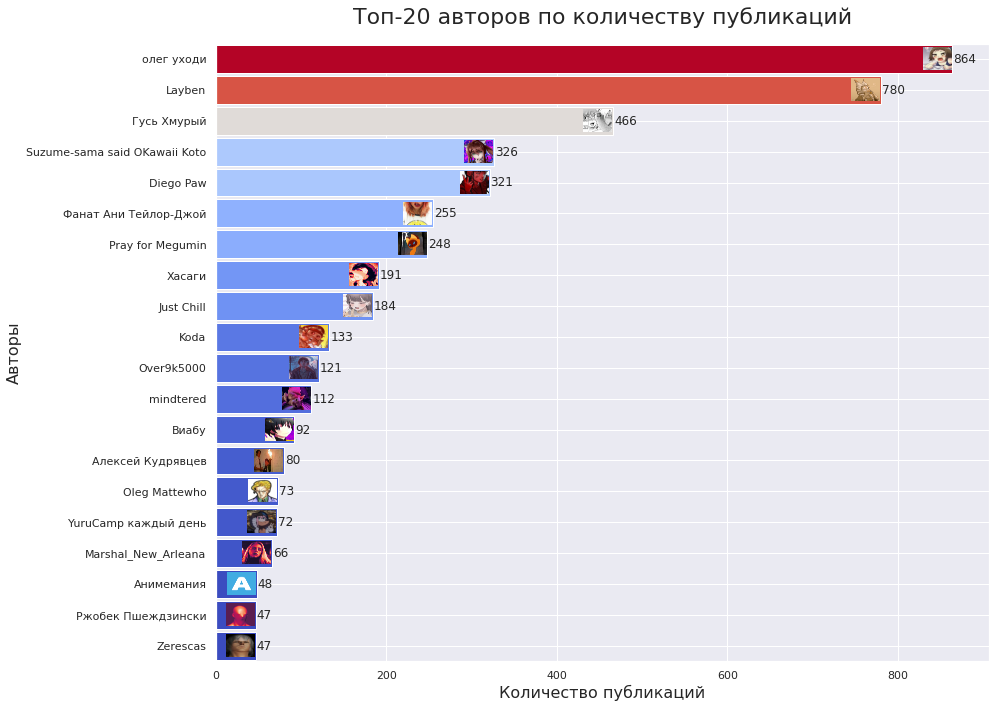

In [25]:
plt.rcParams["figure.figsize"] = [14, 10]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 35, value - 2, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def top_bar_plotting(dataframe: pd.DataFrame, values: pd.Series, path: str, 
                     colormap: str, title: str, ylabel: str, xlabel: str):
    """Function for plotting barchart (seaborn) with some colormap.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Dataframe for which the barplot is plotted. Must include author_name and author_avatar_url.
        
    values : pd.Series
        Data for barchart.
        
    path : str
        Path for saving image.
        
    colormap : str
        Used colormap. See matplotlib list of colormaps.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    my_cmap = plt.get_cmap(colormap)
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    labels = dataframe.author_avatar_url[::-1]
    values = values[::-1] 

    height = 0.9
    plt.barh(y=dataframe.author_name[::-1], width=values, height=height, 
             color=my_cmap(rescale(values)), 
             align='center')

    cntr = []
    for i, (label, value) in enumerate(zip(labels, values)):
        cntr.append(value)
    
    pic_wide = math.ceil(max(cntr) * 0.05)
    pic_indent = math.ceil(max(cntr) * 0.002)
    
    for i, (label, value) in enumerate(zip(labels, values)):
        im = Image.open(requests.get(label, stream=True).raw)
        plt.imshow(im, extent=[value - pic_wide, value - pic_indent, 
                               i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
        plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')


    plt.xlim(0, max(values) * 1.05)
    plt.ylim(-0.5, len(labels) - 0.5)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=22, pad=20)
    plt.tight_layout()

    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')

    plt.show()
    
    # END OF FUNC

In [ ]:
top_bar_plotting(tmp_posts_1, tmp_posts_1.id, 'test.jpg', 'coolwarm', 
                 'Топ-20 авторов по количеству публикаций', 'Авторы', 'Количество публикаций')

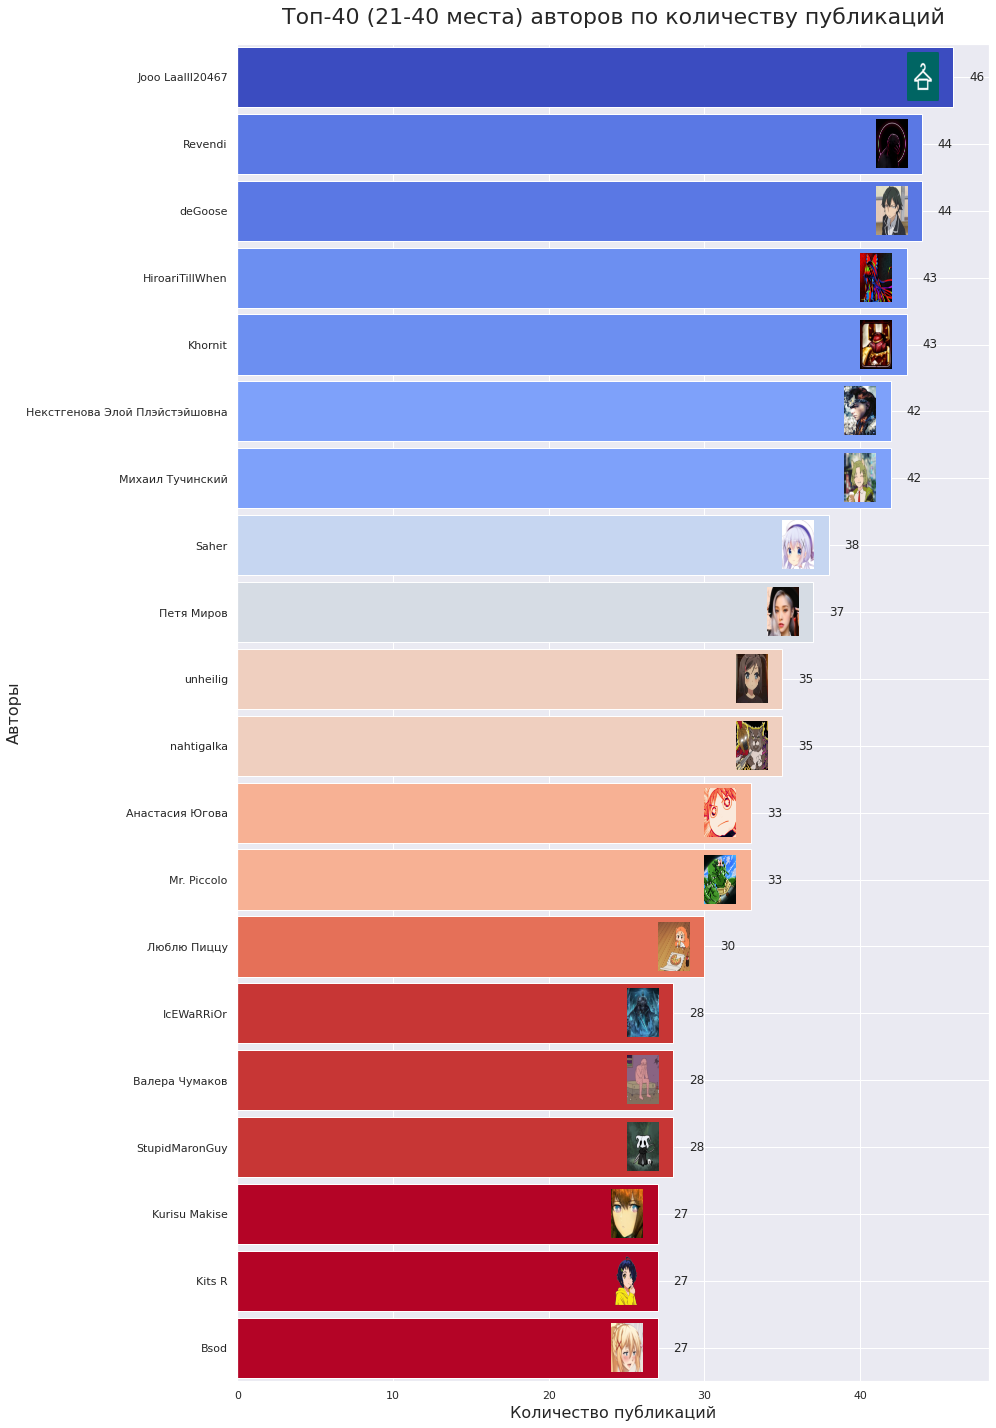

In [130]:
my_cmap = plt.get_cmap("coolwarm_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_2.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_2.author_name[::-1], width=tmp_posts_2.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 3, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

Reposts counts

In [30]:
tmp_posts_alter = df[df.is_repost == True].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False).head(40)
tmp_posts_1 = tmp_posts_alter.iloc[0:20]

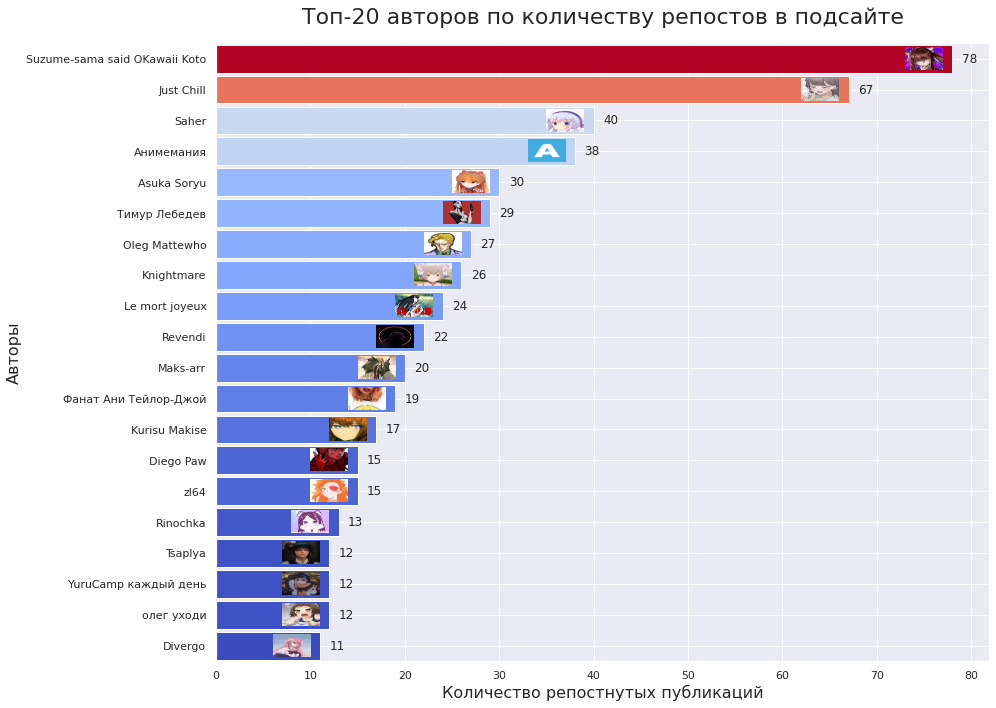

In [31]:
my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 5, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество репостнутых публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству репостов в подсайте', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_reposted.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
top_bar_plotting(tmp_posts_1, 'test.jpg', 'coolwarm_r')

In [ ]:
df.columns

# ---

In [51]:
tmp_likes = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({"likes": "sum"}).sort_values(by="likes", ascending=False).head(40)
tmp_likes_1 = tmp_likes.iloc[0:20]
tmp_likes_2 = tmp_likes.iloc[20:40]
tmp_likes.head(5)

author_name  \
337                     олег уходи   
93                          Layben   
257                    Гусь Хмурый   
156  Suzume-sama said OKawaii Koto   
42                       Diego Paw   

                                     author_avatar_url  likes  
337  https://leonardo.osnova.io/b6f745b6-3963-56d5-...  26556  
93   https://leonardo.osnova.io/7fec5e46-2507-5dcd-...  16945  
257  https://leonardo.osnova.io/8fd51f8a-d2eb-2130-...  13352  
156  https://leonardo.osnova.io/67548a81-f44f-5dc9-...  12489  
42   https://leonardo.osnova.io/7df667af-003c-502d-...   7362

In [ ]:
# top_bar_plotting(tmp_likes_1, tmp_likes_1.likes, 'test.jpg', 'magma')

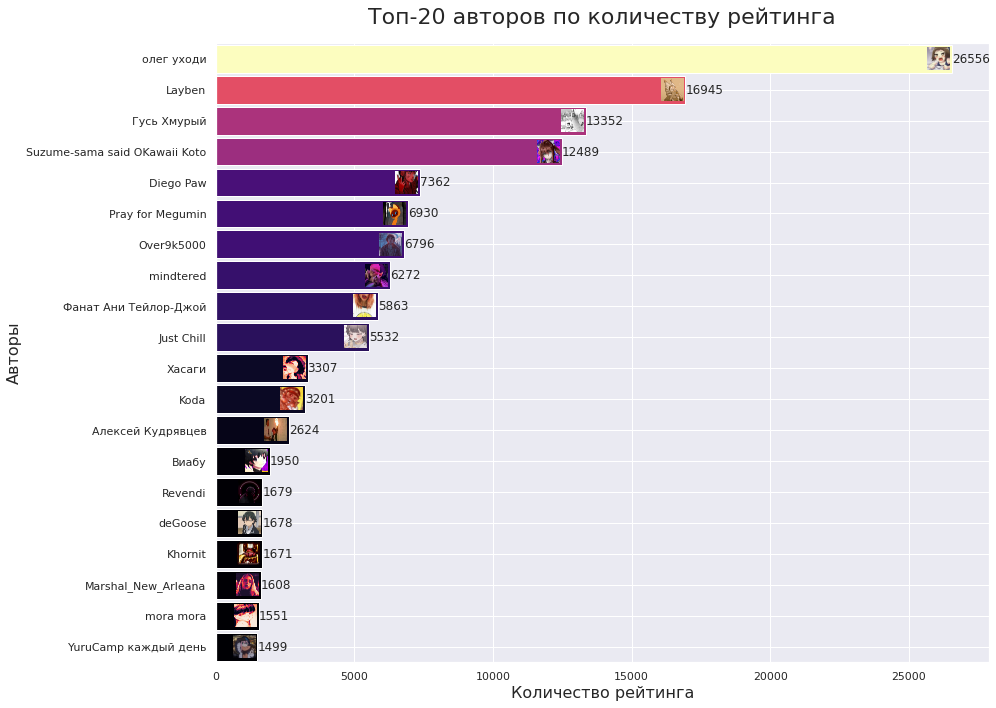

In [28]:
plt.rcParams["figure.figsize"] = [14, 10]
my_cmap = plt.get_cmap("magma")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_1.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_1.author_name[::-1], width=tmp_likes_1.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 900, value - 100, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

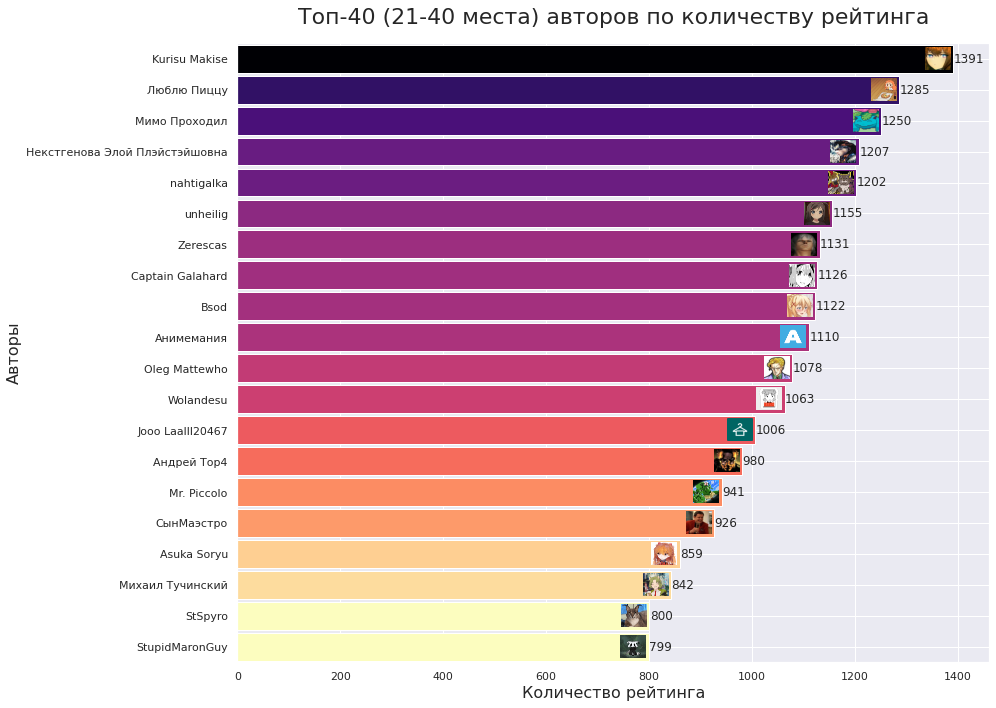

In [29]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_2.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_2.author_name[::-1], width=tmp_likes_2.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 55, value - 5, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
top_bar_plotting(tmp_likes_2, tmp_likes_2.likes, "test.jpg", 'magma_r')

# ---

# ---

In [ ]:
df.head()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, path: str, xlim: int, ci_wide=90, desc_stat='mean', bins='auto'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True, bins=bins)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)
    ax.set_xlim(left=-10, right=xlim)

    plt.tight_layout()
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    pass
    # END OF FUNC

In [ ]:
df.columns

In [ ]:
# df.favorites_count.sort_values(ascending=False).head(20)

In [ ]:
plt.rcParams["figure.figsize"] = [14, 8]

sns.histplot(x = df.likes, data=df, kde=True, bins=70).set_title("Лайки")
# plt.savefig(PATH + "Full_analysis/simple_likes_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.histplot(x = df.likes, data=df, hue='is_repost', kde=True, bins=70).set_title("Лайки")

In [ ]:
histogram_plotting(df.likes, "simple_likes_CI_hist.jpg", 200, desc_stat='median', ci_wide=95, bins=80)
plt.show()

In [ ]:
sns.histplot(x = df.favorites_count, data=df, kde=True, color="r", 
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]).set_title("Добавления в закладки")
# plt.savefig(PATH + "Full_analysis/simple_fav_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.histplot(x = df.favorites_count, data=df, hue='is_repost', kde=True,
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]).set_title("Добавления в закладки")

In [ ]:
histogram_plotting(df.favorites_count, "simple_favs_CI_hist.jpg", 100, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

In [ ]:
sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
             bins=100).set_title("Комментарии")
# plt.savefig(PATH + "Full_analysis/simple_comm_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.comments_count, "simple_comm_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

In [ ]:
df.hits_count.sort_values(ascending=False)

In [ ]:
sns.histplot(x = df.hits_count, data=df, kde=True, color="#b29705", 
             bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")
# plt.savefig(PATH + "Full_analysis/simple_hits_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.hits_count, "simple_hits_CI_hist.jpg", 2000, desc_stat='median', 
                   ci_wide=95, bins=1000)
plt.show()

In [ ]:
sns.histplot(x = np.log(df.hits_count), data=df, kde=True, color="#b29705", 
#              bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")

In [ ]:
from matplotlib.colors import get_named_colors_mapping
get_named_colors_mapping()

In [ ]:
sns.histplot(x = df.symbols, data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
             bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")
# plt.savefig(PATH + "Full_analysis/simple_symb_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.symbols, "simple_symbols_CI_hist.jpg", 3000, desc_stat='median', 
                   ci_wide=95)
plt.show()

In [ ]:
sns.histplot(x = np.log(df.symbols +1), data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
#              bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")

In [ ]:
sns.histplot(x = df.total_mediacontent, data=df, kde=True, color="c", 
                bins=[0,5,10,20,30,40,50,100,150,200,250]
            ).set_title("Количество медиаконтента")
# plt.savefig(PATH + "Full_analysis/simple_media_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.total_mediacontent, "simple_mc_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=[0,5,10,25,50,100])
plt.show()

In [ ]:
sns.histplot(x = np.log(df.total_mediacontent + 1), data=df, kde=True, color="c", 
#                 bins=[0,1,2,3,4,5]
            ).set_title("Количество медиаконтента")

In [ ]:
# plt.rcParams["figure.figsize"] = [16, 14]
# f, axes = plt.subplots(2, 3, )
# f.suptitle("Количественные характеристики публикаций")

# sns.histplot(x = df.likes, data=df, kde=True, ax=axes[0,0], bins=70).set_title("Лайки")
# sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
#              ax=axes[0,1], bins=100).set_title("Комментарии")
# sns.histplot(x = df.favorites_count, data=df, kde=True, color="#de0c62", 
#              bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000], ax=axes[0,2]) \
# .set_title("Добавления в закладки")

In [ ]:
df.columns

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
# df.likes[(df.is_repost == False) & (df.author_type == 2)]

In [ ]:
f, axes = plt.subplots(2, 2, )#sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[0,0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[1,0], bins=30).set_title("Репосты")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[0,1], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[1,1], bins=30).set_title("Репосты")

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[df.is_repost == False], 
             data=df, kde=True, ax=axes[0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[df.is_repost == True], 
             data=df, kde=True, ax=axes[1], bins=30).set_title("Репосты")

In [ ]:
sns.distplot(df.likes, kde=True, color="b")

In [ ]:
len('двенадцать')

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(14, 10))
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df.likes, kde=True, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(df.favorites_count, kde=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(df.hits_count, kde=True, color="g", kde_kws={"shade": True}, ax=axes[0, 2])

# Plot a histogram and kernel density estimate
sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[0, 3])

# sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[1, 0])

plt.setp(axes, yticks=[])
plt.tight_layout()

#### Корреляция

In [ ]:
df.columns

In [ ]:
sns.heatmap(df.loc[:, ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols',
                       'images', 'videos', 'links', 'audio', 'total_mediacontent']].corr(method='pearson'), 
            annot=True)

plt.title('Корреляционная матрица признаков', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/corr_matrix.jpg", dpi=300, bbox_inches='tight')

In [ ]:
pd.plotting.scatter_matrix(df[['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols',
                       'images', 'videos', 'links', 'audio', 'total_mediacontent']], alpha=1, figsize=(20,15));
# plt.savefig(PATH + "Full_analysis/corr_scatter.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# from scipy import stats

# cols = ['comments_count', 'favorites_count', 'hits_count', 'symbols',
#         'images', 'videos', 'links', 'audio', 'total_mediacontent']

# for col in cols: 
#     pearson_coef, p_value = stats.pearsonr(df[col], df['likes'])
#     print("PearsonR между {} и likes {} с P-значением P = {}".format(
#           col, pearson_coef, p_value ))
    
#     if p_value < 0.001:
#         print('Корреляция между {} и likes статистически значимая'.format(col))
#     elif p_value < 0.05:
#         print('Корреляция между {} и likes средняя'.format(col))
#     elif p_value < 0.1:
#         print('Корреляция между {} и likes слабая'.format(col))
#     else:
#         print('Корреляция между {} и likes статистически незначимая'.format(col))
        
#     if pearson_coef > 0 :
#         if pearson_coef > 0.85:
#             print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.75 :
#             print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.60:
#             print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.50 :
#             print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
#     else:
#         if abs(pearson_coef) > 0.85:
#             print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.75 :
#             print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.60:
#             print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.50 :
#             print('Коэффициент ~{} показывает негативную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает негативную слабую связь\n'.format(pearson_coef))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.total_mediacontent+1), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.total_mediacontent+1), y=np.log(df.likes+10))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.symbols+10), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.symbols+10), y=np.log(df.likes+10))

In [ ]:
sns.scatterplot(data=df, x='symbols', y='likes')
plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством символов и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_symbols.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.scatterplot(data=df, x='total_mediacontent', y='likes')
plt.xlabel('Количество медиаконтента в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_media.jpg", dpi=300, bbox_inches='tight')

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x='symbols', y='total_mediacontent', hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Количество медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x=np.log(df.symbols + 1), y=np.log(df.total_mediacontent + 1), hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Логарифм от количества символов в публикации', fontsize=16)
plt.ylabel('Логарифм от количества медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_log_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
sns.set()
ax = sns.scatterplot(x=np.log(df.words + 1), y=np.log(df.total_mediacontent + 1), hue='likes', 
                     palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Логарифм от количества слов в публикации', fontsize=16)
plt.ylabel('Логарифм от количества медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_log_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['author_name']).agg({'id': 'count', 'likes': ['max', 'sum']}) \
    .sort_values(by=("id",'count'), ascending=False)

In [ ]:
df.groupby(['author_name', 'is_repost']).agg({'id': 'count', 'likes': ['max', 'sum']}).sort_values(by=("id",'count'), ascending=False)

https://stackoverflow.com/questions/62884183/trying-to-add-a-colorbar-to-a-seaborn-scatterplot

https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

https://stackoverflow.com/questions/33436221/displaying-rotatable-3d-plots-in-ipython-or-jupyter-notebook

https://matplotlib.org/2.2.5/gallery/mplot3d/rotate_axes3d.html

https://stackoverflow.com/questions/49981313/rotate-interactively-a-3d-plot-in-python-matplotlib-jupyter-notebook

https://stackoverflow.com/questions/14261903/how-can-i-open-the-interactive-matplotlib-window-in-ipython-notebook

https://stackoverflow.com/questions/38326983/how-to-rotate-a-3d-surface-in-matplotlib

https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

In [ ]:
# %matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [12, 16]

x,y,z = df.symbols.values, df.total_mediacontent.values, df.likes.values
# x = x.reshape(-1,1)
# y = y.reshape(-1,1)
# z = z.reshape(-1,1)
# x_scaled = StandardScaler().fit_transform(x)
# y_scaled = StandardScaler().fit_transform(y)
# z_scaled = StandardScaler().fit_transform(z)

fig = plt.figure()
ax = Axes3D(fig)
# # surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.01)
# # fig.colorbar(surf, shrink=0.05, aspect=50)
# # plt.show()

# c = np.arange(len(z_scaled)) / len(z_scaled)
c = np.arange(len(z)) / len(z)
# p = ax.scatter3D(x_scaled, y_scaled, z_scaled, c=c)
ax.scatter3D(x, y, z, c=c)

plt.title('3D диаграмма рассеяния')
plt.xlabel('Количество символов в публикациях')
plt.ylabel('Количество медиаконтента в публикациях')

In [ ]:
# plt.rcParams["figure.figsize"] = [14, 10]

# def histogram_plotting(srs: pd.Series, ci_wide=90, desc_stat='mean'):
#     """Function for plitting histogram (seaborn) with custom confidence interval
#     and descriptive statistics.
    
#     Parameters
#     ----------
#     srs : pd.Series
#         Data for which the histogram is plotted. 
        
#     ci_wide : int, default=90
#         Wide of confidence interval in percents.
        
#     desc_stat : str, default="mean"
#         Calculated descriptive statistics.

#     Returns
#     -------
#         None. Printing histogram.
    
#     """
       
#     ci = (100 - ci_wide) / 200
#     confidence_interval = list(srs.quantile([ci, 1-ci]))
    
#     ax = sns.histplot(srs, kde=True, bins='auto')
#     max_bar_height = max([h.get_height() for h in ax.patches])
    
#     ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
#     for x in confidence_interval:
#         ax.plot([x, x], [0, max_bar_height*1.1], color='black')
#         ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
#     ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
#                 horizontalalignment='center', verticalalignment='center')

#     descriptive_statistics = getattr(srs, desc_stat)()

#     ax.plot([descriptive_statistics, descriptive_statistics], 
#             [0, max_bar_height*1.05], color='black', linestyle='--')
    
#     ax.text(descriptive_statistics, max_bar_height*0.15, 
#             desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
#             bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
#             horizontalalignment='center', verticalalignment='center')
    
#     ax.set_ylim(0, max_bar_height*1.2)

#     plt.tight_layout()
#     plt.show()
    
#     # END OF FUNC

In [ ]:
# df.columns

In [ ]:
# histogram_plotting(df.total_mediacontent, desc_stat='median')

In [ ]:
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue='is_repost', data=df)

In [ ]:
sns.histplot(x = df.comments_count, kde=True)

In [ ]:
# sns.boxplot(data=df, x="is_repost", y="likes")

In [ ]:
a = df.groupby(['author_name']).agg({'id': 'count'})
a[a['id'] > 1].sort_values(by='id', ascending=False)

In [ ]:
a[a['id'] > 100].index

In [ ]:
tmp = df.groupby(['author_name']).agg({'id': 'count'})

In [ ]:
# sns.boxplot(data=df, y="author_name", x="likes")

In [ ]:
# sns.violinplot(y=df.likes)

https://stackoverflow.com/questions/58665252/python-compare-distribution-scipy-ks-2samp-p-value-always-0-0

https://stats.stackexchange.com/questions/18408/two-samples-of-the-same-distribution

https://stackoverflow.com/questions/36846620/comparing-distributions-with-chi-square-in-python

https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [ ]:
from manim import *

In [ ]:
%%manim MovingFrame [CLI options]

class MovingFrame(GraphScene):
    def __init__(self, **kwargs):
        GraphScene.__init__(
            self,
            x_min=-3.5,
            x_max=3.5,
            y_min=-5,
            y_max=5,
            graph_origin=ORIGIN,
            axes_color=BLUE,
            x_labeled_nums=range(-4, 4, 2), # x tickers
            y_labeled_nums=range(-5, 5, 2), # y tickers
            **kwargs
        )
    
    def construct(self):
        self.setup_axes(animate=False)

        # Draw graphs
        func_graph_cube = self.get_graph(lambda x: x**3, RED)
        func_graph_ncube = self.get_graph(lambda x: -x**3, GREEN)

        # Create labels
        graph_lab = self.get_graph_label(func_graph_cube, label="x^3")
        graph_lab2 = self.get_graph_label(func_graph_ncube, label="-x^3", x_val=-3)

        # Create a vertical line
        vert_line = self.get_vertical_line_to_graph(1.5, func_graph_cube, color=YELLOW)
        label_coord = self.input_to_graph_point(1.5, func_graph_cube)
        text = MathTex(r"x=1.5")
        text.next_to(label_coord)
       
        self.add(func_graph_cube, func_graph_ncube, graph_lab, graph_lab2, vert_line, text)
        self.wait()